In [1]:
import numpy as np
import pandas as pd
import glob, os, warnings, shutil, subprocess, re, sys
from Bio import Seq, SeqIO
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import scipy.stats as stbb
import scipy

sys.path.append("/home/sak0914/TRUST_data_processing/scripts")
from utils import *
# from epi_utils import *
# from variant_analysis_utils import *
from dna_features_viewer import BiopythonTranslator
# import panel as pn
# pn.extension('ipywidgets')
# pn.extension()

h37Rv_path = "/n/data1/hms/dbmi/farhat/Sanjana/H37Rv"
h37Rv_seq = SeqIO.read(os.path.join(h37Rv_path, "GCF_000195955.2_ASM19595v2_genomic.gbff"), "genbank")
h37Rv_genes = pd.read_csv(os.path.join(h37Rv_path, "mycobrowser_h37rv_genes_v4.csv"))

h37Rv_regions = pd.read_csv(os.path.join(h37Rv_path, "mycobrowser_h37rv_v4.csv"))

# these are promoters, transcriptional signals, or RNAs. Exclude these
non_coding_regions = h37Rv_regions.query("Feature != 'CDS'").Name.values
promoter_transcriptional_signals = h37Rv_regions.query("Feature in ['promoter', '-10_signal', '-35_signal']").Name.values

# if these remain in the dataframe, then there will be multiple entires for a single gene name, which will cause process_intergenic_variant_WHO_catalog_coord to fail
h37Rv_regions = h37Rv_regions.query("~Feature.str.contains('|'.join(['promoter', 'signal']), case=False)")
assert len(h37Rv_regions) == h37Rv_regions.Name.nunique()

h37Rv_coords = pd.read_csv(os.path.join(h37Rv_path, "h37Rv_coords_to_gene.csv"))
h37Rv_coords_dict = dict(zip(h37Rv_coords["pos"].values, h37Rv_coords["region"].values))

# keep only the 727 patients with high quality WGS and matched patients
# df_WGS = pd.read_csv("/n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_summary.csv")
df_trust_patients = pd.read_csv("./combined_patient_WGS_data_contam_control.csv").dropna(subset=['pid', 'Lineage']).reset_index(drop=True)
print(df_trust_patients.pid.nunique(), df_trust_patients.SampleID.nunique())

for i, row in df_trust_patients.iterrows():
    if not pd.isnull(row['Lineage']):
        if type(row['Lineage']) == str:
            if ',' not in row['Lineage']:
                df_trust_patients.loc[i, 'Lineage'] = str(int(float(row['Lineage'])))
        else:
            df_trust_patients.loc[i, 'Lineage'] = str(int(row['Lineage']))
                
df_trust_patients.loc[df_trust_patients['bl_hiv']==0, 'HIV_CD4'] = 0
df_trust_patients.loc[(df_trust_patients['bl_hiv']==1) & (df_trust_patients['bl_cd4'] >= 200), 'HIV_CD4'] = 1
df_trust_patients.loc[(df_trust_patients['bl_hiv']==1) & (df_trust_patients['bl_cd4'] < 200), 'HIV_CD4'] = 2

# isolates with matched LR sequencing (including samples from the same patient where only 1 sample had LR done)
isolates_with_LR = pd.read_csv("TRUST_isolates_long_read_aln.tsv", sep='\t', header=None)

TRUST_data_dir = "/home/sak0914/TRUST_data_processing"
processed_data_dir = './processed_data'
CNN_results_dir = "/n/data1/hms/dbmi/farhat/Sanjana/CNN_results"

df_TCC = pd.read_csv(f"{TRUST_data_dir}/processed_data/imputed_TCC.csv")
df_final_outcomes = pd.read_csv(f"{TRUST_data_dir}/processed_data/tx_outcomes.csv")

silent_lst = ['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant']
out_dir = "/n/data1/hms/dbmi/farhat/Sanjana/TRUST_lowAF"

418 747


In [200]:
df_TTP_smear, df_TCC, df_combined_culture_results = get_combined_culture_results(df_full)

In [4]:
# to_studyto_treatment_outcome column. 
# Other descriptions in to_studyto_other_treatment_outcome
# additional comments in to_comments_treatment_outcome
treatment_outcome_dict = {1: 'cure',
                          2: 'complete',
                          3: 'defaulted', # typically they stopped taking treatment entirely, not just interruption. May have been doctor-recommended, like due to liver injury or something
                          4: 'failure',
                          5: 'extension',
                          6: 'death',
                          7: 'transferred',
                          8: 'lost_fu',
                          9: 'other'
                        }

# esp_reason_end_of_study_parti column
# Other descriptions in esp_reasonoth_end_of_study_parti
esp_dict = {1: 'complete', # completed all study requirements
            2: 'inappropriate', # should not have been included in the study
            3: 'withdrew',
            4: 'failure', # includes both groups 4 and 5 in treatment_outcome_dict, meaning the patient was culture positive at month 5 or tx was extended
            5: 'relapse',
            6: 'moved', # moved/transferred out,
            7: 'lost_fu',
            8: 'death',
            9: 'other'
            }

# Variants Present in ≥N% of Isolates

https://pmc.ncbi.nlm.nih.gov/articles/PMC11459938/

This paper did in vitro selection using artemisinin, an antimaliarial. They found mutations in glpK (multiple frameshifts in the homopolymeric tract) and glpQ1 (1 frameshift = 4315194	ATC>AC)

# Get Final List of pids to use for the analysis

## Separate F2 ≤ 0.03 and F2 > 0.03 analyses

In [5]:
pids_for_analysis = df_trust_patients.copy()
pids_for_analysis['Lineage'] = pids_for_analysis['Lineage'].astype(str)
pids_for_analysis.pid.nunique(), pids_for_analysis.SampleID.nunique(), len(pids_for_analysis)

(418, 747, 747)

In [6]:
# pids_for_analysis = pids_for_analysis.query("pid not in @exclude_pids").reset_index(drop=True)
print(pids_for_analysis.pid.nunique(), pids_for_analysis.SampleID.nunique(), len(pids_for_analysis))

F2_thresh = 0.03
pids_for_analysis['high_F2'] = (pids_for_analysis['F2'] > F2_thresh).astype(int)

# at least 1 of the 2 WHO samples has a high F2 score
pids_for_analysis['pid_high_F2'] = pids_for_analysis.groupby('pid')['high_F2'].transform(lambda x: np.max(x))

418 747 747


In [77]:
low_F2_pids = pids_for_analysis.query("pid_high_F2 == 0")
high_F2_pids = pids_for_analysis.query("pid_high_F2 == 1")

print(f"{low_F2_pids.pid.nunique()} pids with F2 ≤ {F2_thresh}")
print(f"{high_F2_pids.pid.nunique()} pids with F2 > {F2_thresh}")

392 pids with F2 ≤ 0.03
26 pids with F2 > 0.03


In [8]:
# HT_regions = find_HT_regions(str(h37Rv_seq.seq))
# HT_regions['Region'] = HT_regions['POS'].map(h37Rv_coords_dict)
HT_regions = pd.read_csv("nucleotide_runs_all_lengths.csv")
print(f"{len(HT_regions)} runs of at least 2")

HT_nucs = []

for i, row in HT_regions.query("Length >= 3").iterrows():
    # don't need to add 1 to the end because the start is one of the N nucleotides
    # BUT add 1 bp to the front and back so that you include variants that occur adjacent to an HT region, not just within it
    HT_nucs += list(np.arange(row['POS'] - 1, row['POS'] - 1 + row['Length'] + 1))

HT_nucs = np.unique(HT_nucs)
print(f"{len(HT_nucs)} nucleotides are in homopolymeric tracts")

880248 runs of at least 2
730854 nucleotides are in homopolymeric tracts


In [9]:
pids_for_longitudinal_analysis = pd.read_csv(f"{processed_data_dir}/pids_with_longitudinal_sampling.csv")
exclude_pids = pids_for_longitudinal_analysis.query("F2 > 0.03").pid.unique()

_, sample_1_variants_longitudinal, sample_2_variants_longitudinal = get_matrix_of_HT_indels(f"{processed_data_dir}/full_genome", 
                                                                            pids_for_longitudinal_analysis.query("pid not in @exclude_pids"), # include only pids with an F2 score below the threshold
                                                                            HT_nucs,
                                                                            binarize_fixed_variants=False, 
                                                                            fixed_thresh=0.95, 
                                                                            absent_thresh=0.05
                                                                           )

df_variants, sample_1_variants = get_matrix_of_HT_indels(f"{processed_data_dir}/full_genome", 
                                                        pids_for_analysis, # include only pids with an F2 score below the threshold
                                                        HT_nucs,
                                                        sample_2=False,
                                                        binarize_fixed_variants=False, 
                                                        fixed_thresh=0.95, 
                                                        absent_thresh=0.05
                                                       )

indels_difference = sample_2_variants_longitudinal - sample_1_variants_longitudinal
print(indels_difference.shape)

279 samples with 299 variants
418 samples with 370 variants
(279, 299)


# Plot Genomic Locations of the HT Indels

In [145]:
unique_variants = pd.DataFrame(df_variants.groupby(["variant"])['AF'].mean()).reset_index().merge(df_variants[['variant', 'POS', 'GENE']].drop_duplicates('variant'))
# assert len(unique_variants) == indels_difference.shape[1]

# add the number of samples each one occurs in
unique_variants = unique_variants.merge(pd.DataFrame(df_variants.groupby('variant')['SampleID'].nunique()).reset_index()).rename(columns={'SampleID': 'Count'})

# get proportion of isolates with each variant
total_samples = df_variants.SampleID.nunique()
unique_variants['Total'] = total_samples
unique_variants['Proportion'] = unique_variants['Count'] / unique_variants['Total']

len(unique_variants)

378

In [147]:
unique_variants.sort_values('Proportion')

,variant,AF,POS,GENE,Count,Total,Proportion
275,frdB_p.Gly246fs,1.000000,1760164,frdB,1,747,0.001339
209,Rv3903c_p.Pro137fs,1.000000,4390022,Rv3903c,1,747,0.001339
77,Rv0774c_p.Pro64fs,0.811404,868160,Rv0774c,1,747,0.001339
154,Rv2690c_p.Glu49fs,0.107843,3009065,Rv2690c,1,747,0.001339
279,galTa_p.Pro220fs,0.903346,712192,galTa,1,747,0.001339
...,...,...,...,...,...,...,...
25,PPE9_p.Ala169fs,0.996890,467497,PPE9,745,747,0.997323
365,sigM_p.Arg160fs,0.998134,4400660,sigM,747,747,1.000000
130,Rv2250A_p.Gly109fs,0.996901,2525722,Rv2250A,747,747,1.000000
227,ctpI_p.Ser1571fs,0.993761,125830,ctpI,747,747,1.000000


In [12]:
# these are found in nearly all samples, so they get dropped by get_matrix_of_HT_indels, which drops variants present in ≥90% of patients at baseline
set(unique_variants.variant) - set(sample_1_variants.columns)

{'PPE9_p.Ala169fs',
 'Rv2250A_p.Gly109fs',
 'Rv2561_p.Gln66fs',
 'Rv2879c_p.Glu3fs',
 'Rv3750c_c.-15delC,Rv3751_c.-262delG',
 'ctpI_p.Ser1571fs',
 'fadD11.1_p.Cys6fs',
 'sigM_p.Arg160fs'}

In [17]:
df_variants.SampleID.nunique(), df_variants.query("variant=='sigM_p.Arg160fs'").SampleID.nunique(), df_variants.query("variant=='sigM_p.Arg160fs'").pid.nunique()

(747, 747, 418)

In [174]:
class CustomTranslator(BiopythonTranslator):
    
    def __init__(self, allowed_genes, *args, **kwargs):
        self.allowed_genes = set(allowed_genes)
        super().__init__(*args, **kwargs)

    def compute_filtered_features(self, features):
        # Keep only features whose gene name or locus_tag is in the list
        keep_features = []

        for feature in features:
            if feature.type == "CDS":
                if 'gene' in feature.qualifiers and feature.qualifiers['gene'][0] in self.allowed_genes:
                    keep_features.append(feature)
                # elif 'locus_tag' in feature.qualifiers and feature.qualifiers['locus_tag'][0] in self.allowed_genes:
                    # keep_features.append(feature)
        
        return keep_features

In [153]:
unique_variants.query("Proportion < 0.9")

,variant,AF,POS,GENE,Count,Total,Proportion
0,B55-Rv0610c_n.704409_704410insG,0.994985,704409,B55-Rv0610c,2,747,0.002677
1,F6_n.30dupC,0.978926,293628,F6,550,747,0.736278
2,PE35_p.Met4fs,0.997937,4350748,PE35,4,747,0.005355
3,PE6_p.Arg48fs,1.000000,399909,PE6,1,747,0.001339
4,PE8_c.-152_-151insA,0.989747,1163527,PE8-Rv1041c,5,747,0.006693
...,...,...,...,...,...,...,...
373,"whiB5_c.-54delC,Rv0023_c.-99delG",0.995122,27495,whiB5-Rv0023,1,747,0.001339
374,whiB5_p.Val124fs,0.996909,27072,whiB5,4,747,0.005355
375,whiB6_p.Gly74fs,0.990826,4338302,whiB6,4,747,0.005355
376,whiB6_p.Leu31fs,0.132626,4338435,whiB6,1,747,0.001339


In [182]:
df_variants.query("pid=='T0090' & variant.str.contains('espR')")#[['GENE']]

,pid,SampleID,POS,REF,ALT,QUAL,DP,DPB,RO,AO,...,variant,SRP_prob,SAP_prob,HT,Diff_NT,Unique_Change_NT,Phase_Variant,SNP,Sampling_Week,Paired_Sample_Num
4718,T0090,MFS-355,4323354,C,CG,1.338010e-13,280,287.636,197,81.0,...,espR_c.-145_-144insG,0.031521,0.053851,1,G,1.0,1,0,1.0,1
4759,T0090,MFS-356,4323354,C,CG,9.651570e+03,320,349.000,0,318.0,...,espR_c.-145_-144insG,NaN,0.300418,1,G,1.0,1,0,6.0,2


In [192]:
df_variants.query("pid=='T0090' & variant.str.contains('espR')")[['pid', 'SampleID', 'variant', 'AF', 'AO', 'DP', 'SAF', 'SAR', 'SAP_prob']]

,pid,SampleID,variant,AF,AO,DP,SAF,SAR,SAP_prob
4718,T0090,MFS-355,espR_c.-145_-144insG,0.289286,81.0,280,31.0,50.0,0.053851
4759,T0090,MFS-356,espR_c.-145_-144insG,0.993750,318.0,320,150.0,168.0,0.300418


In [193]:
df_variants.query("pid=='T0052' & variant.str.contains('espR')")[['pid', 'SampleID', 'variant', 'AF', 'AO', 'DP', 'SAF', 'SAR', 'SAP_prob']]

,pid,SampleID,variant,AF,AO,DP,SAF,SAR,SAP_prob
2554,T0052,MFS-30,espR_c.-145_-144insG,0.991228,226.0,228,101.0,125.0,0.139808
2594,T0052,MFS-31,espR_c.-145_-144insG,0.986207,286.0,290,125.0,161.0,0.051876


In [ ]:
df_variants.query("pid=='T0052' & variant.str.contains('espR')")[['pid', 'SampleID', 'variant', 'AF', 'AO', 'DP']]

In [187]:
indels_difference.loc['T0090', 'espR_c.-145_-144insG']

0.7044642857142858

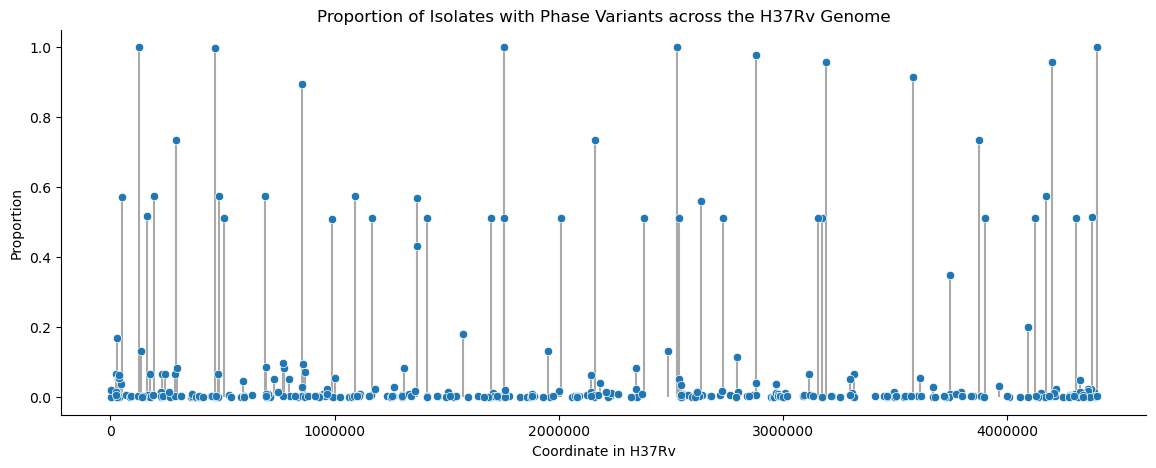

In [175]:
fig, ax = plt.subplots(figsize=(14, 5))

thresh = 1
df_plot = unique_variants.query("Proportion <= @thresh")

sns.scatterplot(data=df_plot,
                x='POS',
                y='Proportion',
                ax=ax
               )

for i, row in df_plot.iterrows():
    plt.vlines(x=row['POS'], color='darkgray', ymin=0, ymax=row['Proportion'], zorder=0)

# plt.yscale('log')

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')

# plt.xlim(-10, len(h37Rv_seq.seq))
plt.xlabel("Coordinate in H37Rv")
plt.title("Proportion of Isolates with Phase Variants across the H37Rv Genome")
sns.despine()
plt.savefig("./results/figures/phase_variant_frequencies.svg", bbox_inches='tight')

In [159]:
unique_variants.query("Proportion < 0.9 & Proportion > 0.8")

,variant,AF,POS,GENE,Count,Total,Proportion
74,Rv0759c_c.-96delG,0.977329,854252,Rv0759c-Rv0760c,668,747,0.894244


In [160]:
samples_with_variant_1 = df_variants.query("variant=='Rv0759c_c.-96delG'").SampleID.unique()
samples_with_variant_2 = df_variants.query("variant=='Rv0759c_c.-96delGG'").SampleID.unique()

In [161]:
set(samples_with_variant_1).intersection(samples_with_variant_2)

set()

In [138]:
unique_variants.sort_values("Count")

,variant,AF,POS,GENE,Count
275,frdB_p.Gly246fs,1.000000,1760164,frdB,1
209,Rv3903c_p.Pro137fs,1.000000,4390022,Rv3903c,1
77,Rv0774c_p.Pro64fs,0.811404,868160,Rv0774c,1
154,Rv2690c_p.Glu49fs,0.107843,3009065,Rv2690c,1
279,galTa_p.Pro220fs,0.903346,712192,galTa,1
...,...,...,...,...,...
25,PPE9_p.Ala169fs,0.996890,467497,PPE9,745
365,sigM_p.Arg160fs,0.998134,4400660,sigM,747
130,Rv2250A_p.Gly109fs,0.996901,2525722,Rv2250A,747
227,ctpI_p.Ser1571fs,0.993761,125830,ctpI,747


In [176]:
# frequency_thresh = 10

# fig, (ax1, ax2) = plt.subplots(
#     2, 1, figsize=(20, 5), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
# )
# plt.title(f"Phase variations in {len(genes_lst)} genes")

# h37Rv_seq = SeqIO.read(os.path.join(h37Rv_path, "GCF_000195955.2_ASM19595v2_genomic.gbff"), "genbank")

# plot_variants = unique_variants.query("Count >= @frequency_thresh")

# genes_lst = []

# for i, row in plot_variants.iterrows():
#     # variants that span multiple genes need to be split
#     genes_lst += row['GENE'].split('-')

# genes_lst = np.unique(genes_lst)

# translator = CustomTranslator(allowed_genes=genes_lst)
# graphic_record = translator.translate_record(h37Rv_seq)

# # graphic_record = BiopythonTranslator().translate_record(h37Rv_seq)
# graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)

# sns.scatterplot(data=plot_variants,
#                 x='POS',
#                 y='AF',
#                 color='black',
#                 ax=ax2
#             )

# for i, row in plot_variants.iterrows():
#     plt.vlines(x=row['POS'], color='darkgray', ymin=0, ymax=row['AF'], zorder=0)

# plt.xlim(0, len(h37Rv_seq.seq))
# plt.ylim(0, 1.05)

# sns.despine()
# plt.show()

In [ ]:
# # fig, ax = plt.subplots(figsize=(14, 10))
# fig, ax = plt.subplots(figsize=(10, 6))

# sns.heatmap(indels_difference.T,
#            center=0,
#            cmap=sns.color_palette("vlag", as_cmap=True),
#            )

# plt.xticks([])
# sns.despine()
# # plt.show()
# plt.savefig("results/figures/indels_ROI.svg", bbox_inches='tight')

In [19]:
def combine_frameshifts_single_gene(df, difference=False):

    df_grouped_by_gene = df.copy()
    
    # only keep track of the genes with indels in coding regions
    grouped_variants_dict = {}
    
    for col in df_grouped_by_gene.columns:
    
        if '_p.' in col:
            gene = col.split('_p.')[0]
            
            if gene not in grouped_variants_dict.keys():
                grouped_variants_dict[gene] = [col]
            else:
                grouped_variants_dict[gene] += [col]
    
    for gene, variants in grouped_variants_dict.items():

        if difference:
#             # if there are samples with more than 1 variant per gene, trigger this
#             unique_variants_per_gene = df_grouped_by_gene[variants].replace(0, np.nan).count(axis=1).unique()
        
#             if np.max(unique_variants_per_gene) > 1:
#                 raise ValueError(f"Some isolates have multiple variants per {gene}")
#             else:
#                 # create a combined variable.
#                 # replace 0s with NAs because NA is always returned by np.max() and np.min() in python
#                 df_grouped_by_gene[gene] = df_grouped_by_gene[variants].replace(0, np.nan).max(axis=1).fillna(0)

            # create a combined variable by averaging the differences. 
            # Average because sometimes 1 could be positive and 1 could be negative, but the magnitudes are really small, so they're both considered fixed
            
            df_grouped_by_gene[gene] = df_grouped_by_gene[variants].mean(axis=1).fillna(0)
        
        # do a simple maximum because these dataframes are not measuring differences (so they can't be negative). 
        else:
            # create a combined variable
            df_grouped_by_gene[gene] = df_grouped_by_gene[variants].max(axis=1)

        # remove the component variables
        df_grouped_by_gene = df_grouped_by_gene.drop(columns=variants, axis=1)

    print(f"Collapsed {df.shape[1]} variants into {df_grouped_by_gene.shape[1]}")

    return df_grouped_by_gene, list(grouped_variants_dict.keys())

In [20]:
sample_1_variants, genes_with_frameshifts = combine_frameshifts_single_gene(sample_1_variants, difference=False)
# sample_2_variants, _ = combine_frameshifts_single_gene(sample_2_variants, difference=False)
indels_difference, _ = combine_frameshifts_single_gene(indels_difference, difference=True)

Collapsed 370 variants into 337
Collapsed 299 variants into 278


In [21]:
def combine_genes_of_similar_pathways(df, dict_of_lists_of_genes_to_group, difference=False):
    '''
    dict_of_lists_of_genes_to_group is a dictionary of lists of genes. Each element is name: list pair. The genes in each list need to combined together. 
    '''
    
    df_grouped_by_pathway = df.copy()
    
    for pathway_name, genes_lst in dict_of_lists_of_genes_to_group.items():
        
        for gene in genes_lst:
            
            if difference:
                df_grouped_by_pathway[pathway_name] = df_grouped_by_pathway[genes_lst].mean(axis=1).fillna(0)

            # do a sum because these dataframes are not measuring differences (so they can't be negative). 
            else:
                # create a combined variable
                df_grouped_by_pathway[pathway_name] = df_grouped_by_pathway[genes_lst].max(axis=1)

        # remove the component variables
        df_grouped_by_pathway = df_grouped_by_pathway.drop(columns=genes_lst, axis=1)

    print(f"Collapsed {df.shape[1]} variants into {df_grouped_by_pathway.shape[1]}")

    return df_grouped_by_pathway

In [22]:
# Mce-family proteins. Exclude mce1R because we don't know what the change in the transcription factor would do. Could be positive or negative, and since we're summing frameshifts, need everything to have hypothesized same direction
# exclude mce2B because the annotation is suspect. According to mycobrowser, Rv0590A is a probable continuation of mce2B (Rv0590).
# Possible nucleotide G missing at 688793 as there are 5 in Mycobacterium bovis but only 4 in CDC1551. 160/279 samples have this G missing, and the others don't. So might be a reference issue
mammalian_cell_entry_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & Product.str.contains('Mce-family')").Name.values
mammalian_cell_entry_genes = list(set(mammalian_cell_entry_genes) - set(['mce1R', 'mce2B']))

# esx genes. Exclude eccC2 because the frameshift is found in ~1/2 of samples? But it's a real variant
esx_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & Product.str.contains('esx', case=False)").Name.values
esx_genes = list(set(esx_genes) - set(['eccC2']))

# virulence_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & (Functional_Category.str.contains('virulence', case=False) | (Product.str.contains('esx', case=False)) | Name.str.contains('mce'))")[['Name', 'Function', 'Product', 'Functional_Category', 'Comments']].Name.values

# metabolism_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & Name not in @virulence_genes & Functional_Category.str.contains('metabolism', case=False)").Name.values
lipid_metabolism_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & Functional_Category=='lipid metabolism'").Name.values

other_metabolism_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & Name not in @lipid_metabolism_genes & Functional_Category.str.contains('metabolism', case=False)").Name.values

# metabolism_genes = h37Rv_regions.query("Name in @genes_with_frameshifts & Name not in @virulence_genes & Functional_Category.str.contains('metabolism', case=False)").Name.values
transcription_factors = h37Rv_regions.dropna(subset='Function').query("Name in @genes_with_frameshifts & Function.str.contains('transcription')").Name.values

gene_grouping_dict = {'mammalian_cell_entry': mammalian_cell_entry_genes, 'esx': esx_genes, 'lipid_metabolism': lipid_metabolism_genes, 'other_metabolism': other_metabolism_genes, 'transcription_factors': transcription_factors}


In [23]:
# h37Rv_genes[['Symbol', 'Functional_Category', 'Function', 'Product']].query("Symbol in @lipid_metabolism_genes")

In [24]:
# h37Rv_regions.query("Name in @genes_with_frameshifts & Name in @lipid_metabolism_genes")[['Name', 'Product', 'Functional_Category', 'Function']]



In [25]:
sample_1_variants_grouped_pathways = combine_genes_of_similar_pathways(sample_1_variants, gene_grouping_dict, difference=False)
# sample_2_variants_grouped_pathways = combine_genes_of_similar_pathways(sample_2_variants, gene_grouping_dict, difference=False)
# indels_difference_grouped_pathways = combine_genes_of_similar_pathways(indels_difference, gene_grouping_dict, difference=True)

Collapsed 337 variants into 243


In [26]:
df_check = sample_1_variants.drop(high_F2_pids.pid.unique(), axis=0)

for col in esx_genes:
    print(col, len(df_check.loc[(df_check[col] >= 0.05) & (df_check[col] <= 0.75)]))

eccD2 0
espK 0
espG2 0
espB 1
espJ 1


In [128]:
col = 'espJ'
df_check.loc[(df_check[col] >= 0.05) & (df_check[col] <= 0.75)][col]

T0067    0.055046
Name: espJ, dtype: float64

In [129]:
col = 'espB'
df_check.loc[(df_check[col] >= 0.05) & (df_check[col] <= 0.75)][col]

T0470    0.428941
Name: espB, dtype: float64

In [13]:
for col in list(gene_grouping_dict.keys()):
    
    print(col, len(sample_1_variants_grouped_pathways.loc[sample_1_variants_grouped_pathways[col] != 0]), len(sample_1_variants_grouped_pathways))

mammalian_cell_entry 51 418
esx 42 418
lipid_metabolism 265 418
other_metabolism 362 418
transcription_factors 248 418


In [203]:
# missing_genes = list(set(genes_with_frameshifts) - set(virulence_genes) - set(metabolism_genes) - set(transcription_factors))
# len(missing_genes)

130

In [290]:
# h37Rv_regions.query("Name in @missing_genes")[['Name', 'Function', 'Product', 'Functional_Category', 'Comments',]]

In [291]:
# h37Rv_regions.query("Name in @missing_genes").Functional_Category.value_counts()

In [15]:
# data_dir = "./processed_data/full_genome"

# df_variants = pd.concat([pd.read_csv(f"{data_dir}/fixed_variants.csv"), pd.read_csv(f"{data_dir}/unfixed_variants.csv")]).query("Phase_Variant==1")
    
# # exclude variants in regions that are RNAs, promoters, or transcriptional signals. So exclude defined annotations that are non-coding
# # NOTE THAT THIS DOES NOT EXCLUDE INTERGENIC REGIONS
# df_variants = df_variants.query("GENE not in @non_coding_regions").reset_index(drop=True)

In [27]:
freq_thresh = 1
variants_with_change_thresh = []

for col in indels_difference.columns:
    if len(indels_difference.loc[indels_difference[col].abs() >= 0.1]) >= freq_thresh:
        variants_with_change_thresh.append(col)

In [ ]:
# for col in indels_difference.columns:
#     print(indels_difference.loc[indels_difference[col] != 0])

In [ ]:
df_variants.query("variant.str.contains('Rv0759c')").variant.value_counts()

variant
Rv0759c_c.-96delG         668
Rv0759c_c.-97_-96delGG     22
Rv0759c_c.-96_-95insG       2
Name: count, dtype: int64

In [29]:
df_variants.query("variant=='Rv0759c_c.-96delG'").pid.nunique() / df_variants.pid.nunique()

0.9019138755980861

In [42]:
df_variants.query("variant=='Rv0759c_c.-97_-96delGG'").pid.nunique()

11

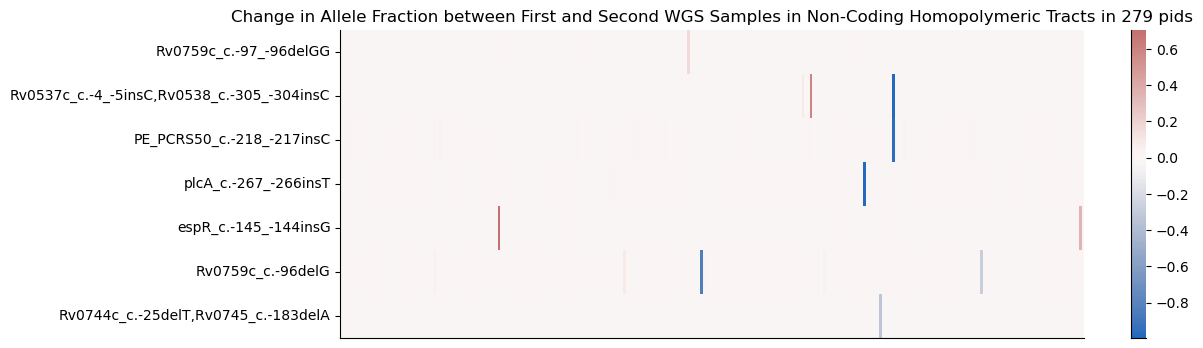

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_cols = list(set(indels_difference.columns[~indels_difference.columns.isin(genes_with_frameshifts)]).intersection(variants_with_change_thresh))

sns.heatmap(indels_difference[plot_cols].T,
            center=0,
            cmap=sns.color_palette("vlag", as_cmap=True),
            ax=ax,
            xticklabels=False,
           )

sns.despine()
plt.title(f"Change in Allele Fraction between First and Second WGS Samples in Non-Coding Homopolymeric Tracts in {indels_difference.shape[0]} pids")
plt.savefig("./results/figures/longitudinal_changes_noncoding_regions.svg", bbox_inches='tight')

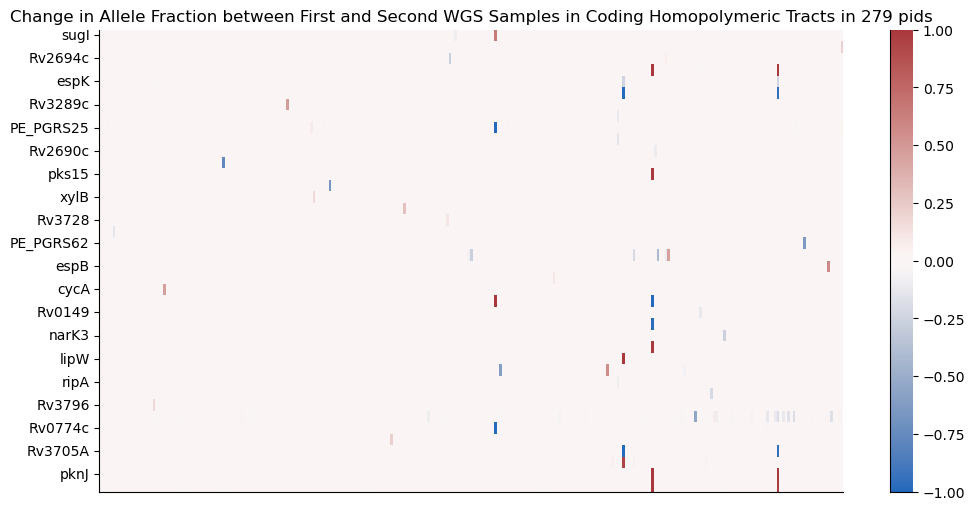

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_cols = list(set(genes_with_frameshifts).intersection(variants_with_change_thresh))

sns.heatmap(indels_difference[plot_cols].T,
            center=0,
            cmap=sns.color_palette("vlag", as_cmap=True),
            ax=ax,
            xticklabels=False,
           )

sns.despine()
plt.title(f"Change in Allele Fraction between First and Second WGS Samples in Coding Homopolymeric Tracts in {indels_difference.shape[0]} pids")
plt.savefig("./results/figures/longitudinal_changes_coding_regions.svg", bbox_inches='tight')

# Cox Models

In [32]:
df_full = pd.read_csv("patient_data/20240826_metadata_MIC_method_updates.csv")
df_full = add_household_numbers(df_full)

df_trust_patients, TRUST_phenos, df_pred_combined = read_combine_all_TRUST_data("./patient_data/combined_patient_WGS_data_contam_control.csv", 
                                                                                {'RIF': 'lineage_amino_acid', 
                                                                                 'INH': 'lineage_amino_acid', 
                                                                                 'EMB': 'lineage_amino_acid', 
                                                                                 'PZA': 'amino_acid'}, # dictionary for which model to get predictions for
                                                                                CNN_results_dir="/n/data1/hms/dbmi/farhat/Sanjana/CNN_results", 
                                                                                baseline_only=True
                                                                               )

# also run on this so that the variables are in better encodings
df_trust_patients = process_patient_metadata_better_encodings(df_trust_patients, TRUST_phenos, include_TTP=False)
df_trust_patients = add_household_numbers(df_trust_patients)

print(f"{df_trust_patients.merge(df_TCC, on='pid').pid.nunique()}/{df_trust_patients.pid.nunique()} patients with valid TCC and WGS")

82 patients share a household with another patient, accounting for 32 households
402 unique households across 452 patients
418 patients with any WGS samples
418 patients with uncontaminated WGS samples
408 patients with uncontaminated WGS samples taken in the first 2 weeks

2 patients: ['T0137' 'T0402'] have multiple sequences at the same timepoint
Removing 1 patients: ['T0402'] because there are multiple WGS samples at the same timepoint with different lineages
409 patients have MICs for RIF
409 patients have MICs for INH
409 patients have MICs for EMB
288 patients have MICs for PZA
405 patients have measured MICs in the first 2 weeks

Found predicted RIF MICs for 407 pids
Found predicted INH MICs for 407 pids
Found predicted EMB MICs for 407 pids
Found predicted PZA MICs for 407 pids
407 patients have predicted MICs
68 patients share a household with another patient, accounting for 31 households
370 unique households across 407 patients
379/407 patients with valid TCC and WGS


In [34]:
set(df_trust_patients.pid) - set(TRUST_phenos.pid)

{'T0244', 'T0360'}

In [35]:
set(df_trust_patients.pid) - set(df_pred_combined.pid)

set()

## TCC

In [36]:
def drop_duplicate_patients(imputed_data_fName, imputed_TCC_fName):

    # read in the imputed patient data
    df_imputed = pd.read_csv(imputed_data_fName).drop_duplicates()
    
    # read the imputed TCC results (this is only TCC, not the rest of the patient data)
    df_TCC_imputed_all = pd.read_csv(imputed_TCC_fName).rename(columns={'culture_convert_imputed': 'culture_convert', 'TCC_imputed': 'TCC'})
    
    # df_full.dropna(subset='esp_reasonoth_end_of_study_parti').query("esp_reasonoth_end_of_study_parti.str.contains('|'.join(['resist', 'regimen']), case=False)")[['pid', 'to_studyto_treatment_outcome', 'to_comments_treatment_outcome', 'esp_reason_end_of_study_parti', 'esp_reasonoth_end_of_study_parti']]
    
    # T0122 was diagnosed with MDR. T0137 died within 3 weeks of starting treatment, but their ESP reason says 'Changed to "liver-friendly regimen". No longer on first line drugs'
    # they are removed by the TCC exclusion criterion because they died so soon and don't have enough cultures sampled.
    exclude_pids_resistance = ['T0122', 'T0137']
        
    # T0322 says they were started on RHZE + levofloxacin
    # T0330 is fine, says they had a positive month 5 culture and were RIF- and INH-sensitive
    # T0355 started MDR regimen upon incarceration
    exclude_pids_diff_regimen = ['T0322', 'T0355']
    
    # add the household numbers
    df_TCC_imputed_all = df_TCC_imputed_all.merge(df_full[['pid', 'household_num']])
    
    # add the unique patient identifiers (just integers)
    unique_cluster_dict = get_unique_patient_ID_dict(df_full)

    df_TCC_imputed_all['unique_patient'] = df_TCC_imputed_all['pid'].map(unique_cluster_dict).astype(int)
    
    # keep only the first instance for re-enrolled patients
    df_TCC_imputed_all = df_TCC_imputed_all.sort_values(['imp_num', 'pid', 'unique_patient']).drop_duplicates(['imp_num', "unique_patient"], keep='first').merge(df_trust_patients[['pid']].drop_duplicates())
    print(f"{df_TCC_imputed_all.pid.nunique()} unique patients across {df_TCC_imputed_all.household_num.nunique()} households")
    
    # 3 of the above excluded pids are in here
    df_TCC_imputed_all = df_TCC_imputed_all.query("pid not in @exclude_pids_resistance and pid not in @exclude_pids_diff_regimen").merge(df_trust_patients[['pid']].drop_duplicates()).reset_index(drop=True)
    
    print(f"{df_TCC_imputed_all.pid.nunique()} unique patients across {df_TCC_imputed_all.household_num.nunique()} households")
    
    df_imputed = df_imputed.query("pid in @df_TCC_imputed_all.pid")

    return df_imputed, df_TCC_imputed_all

In [37]:
df_original_imputation, df_imputed_TCC = drop_duplicate_patients("imputation/data_TCC.csv", "imputation/TCC.csv")

17 patients are duplicated across 35 pids
365 unique patients across 337 households
362 unique patients across 334 households


In [38]:
# df_imputed_patient_data = df_original_imputation.query("pid in @low_F2_pids.pid")
df_imputed_patient_data = df_original_imputation.query("pid in @pids_for_analysis.pid")
print(f"{df_imputed_patient_data.pid.nunique()} pids for the analysis")

362 pids for the analysis


In [209]:
# df_trust_patients = df_trust_patients.merge(df_imputed_patient_data[['pid', 'predicted_label']].drop_duplicates(), on='pid')

In [39]:
def add_change_to_indel_to_patient_data(df, sample_1_variants, sample_2_variants, indels_difference, variant, freq_thresh=3, include_interaction=True):

    num_samples_with_indel_change = len(indels_difference.loc[indels_difference[variant] != 0])
    
    num_samples_variant_initial = sample_1_variants[variant].sum()
    num_samples_variant_final = sample_2_variants[variant].sum()

    if num_samples_variant_initial < freq_thresh and num_samples_variant_final < freq_thresh:
        print(f"    Fewer than {freq_thresh} patients have {variant} at the beginning and end. Skipping this variant...")
        return None
    
#     if num_samples_with_indel_change < freq_thresh:
#         print(f"    Only {num_samples_with_indel_change} patients have a change in {variant}. Skipping this case...")
#         return None

    # add the indel to the dataframe. Change the name of the column because the format like _p. can mess with the string encoding the formula in the Cox model
    df_with_variant = df.merge(indels_difference[[variant]], left_on='pid', right_index=True).rename(columns={variant: 'Indel_Change'})

    # also add an AF variable for whether the variable was present at baseline
    df_with_variant = df_with_variant.merge(sample_1_variants[[variant]], left_on='pid', right_index=True).rename(columns={variant: 'Indel_Sample1'})

    # include interaction between the two
    if include_interaction:
        df_with_variant['Indel_Sample1_x_Change'] = df_with_variant['Indel_Sample1'] * df_with_variant['Indel_Change']

    return df_with_variant

In [40]:
def add_indel_at_baseline_to_patient_data(df, sample_1_variants, variant, freq_thresh=3):
    
    num_samples_variant_initial = sample_1_variants[variant].sum()

    if num_samples_variant_initial < freq_thresh:
        print(f"    Fewer than {freq_thresh} patients have {variant} at at baseline. Skipping this variant...")
        return None
    
    # also add an AF variable for whether the variable was present at baseline
    df_with_variant = df.merge(sample_1_variants[[variant]], left_on='pid', right_index=True).rename(columns={variant: 'Indel_Sample1'})

    return df_with_variant

In [41]:
# def add_initial_final_indel_to_patient_data(df, sample_1_variants, sample_2_variants, indels_difference, variant, freq_thresh=5, invert_indel_change=False):

#     num_samples_variant_initial = sample_1_variants[variant].sum()
#     num_samples_variant_final = sample_2_variants[variant].sum()

#     if num_samples_variant_initial < freq_thresh and num_samples_variant_final < freq_thresh:
#         print(f"    Fewer than {freq_thresh} patients have {variant} at the beginning and end. Skipping this variant...")
#         return None

#      # add the indel presence at the baselina and follow-up to the dataframe. Change the name of the column because the format like _p. can mess with the string encoding the formula in the Cox model
#     df_with_variant = df.merge(sample_1_variants[[variant]], left_on='pid', right_index=True).rename(columns={variant: 'Indel_Sample1'})
#     df_with_variant = df_with_variant.merge(sample_2_variants[[variant]], left_on='pid', right_index=True).rename(columns={variant: 'Indel_Sample2'})

#     # include interaction between the two
#     df_with_variant['Indel_Sample1_x_Sample2'] = df_with_variant['Indel_Sample1'] * df_with_variant['Indel_Sample2']

#     return df_with_variant

# Build a patient data model using all relevant patient predictors

## First determine the model form by checking the proportional hazards assumption

In [118]:
cols_lst = [
            'screen_sex',
            'screen_years',
            'bl_bmi', # numerical BMI
            'fstrom1_baseline', # smoking yes or no
            # 'smoked_substance_use',
            'HIV_CD4',
            'bl_prevtb',
            'smear_pos_no_contam_sputum_specimen_1', # binary variable for smear positivity at baseline
            'diabetes',
            'high_lung_involvement',
            'adherence_12week',
            'cxr_cavity_chest_radiograph_1',
            # 'TTP',
            # 'underweight',
            'RIF_AUC',
            'INH_AUC',
            'EMB_AUC',
            'PZA_AUC',
            'F2'
           ]

# try these first, as they were required for the full TCC model
stratify_covariates = ['smear_pos_no_contam_sputum_specimen_1', 'high_lung_involvement', 'cxr_cavity_chest_radiograph_1']

In [165]:
df_test_results, df_samples_imputations, cph_models_imputations = fit_cox_models_all_imputations(df_trust_patients,
                                                                                                  df_pred_combined,
                                                                                                   TRUST_phenos,
                                                                                                   df_imputed_patient_data,
                                                                                                  df_imputed_TCC,
                                                                                                  cols_lst,
                                                                                                  event_col = 'culture_convert',
                                                                                                  time_col = 'TCC',
                                                                                                  invert_OR=True,
                                                                                                  stratify_variables=stratify_covariates,
                                                                                                 )

df_violating_covariates = []

for model_idx in range(len(cph_models_imputations)):

    df_proportional_hazards = lifelines.statistics.proportional_hazard_test(cph_models_imputations[model_idx], df_samples_imputations[model_idx], time_transform='rank').summary

    # diabetes has a p-value of like 0.0105
    violating_covariates = df_proportional_hazards.reset_index()[['index', 'p']].rename(columns={'index': 'covariate'})
    
    violating_covariates['imp_num'] = model_idx + 1

    df_violating_covariates.append(violating_covariates)

df_violating_covariates = pd.concat(df_violating_covariates)

df_violating_covariates.query("p <= 0.05")#.covariate.value_counts()#.drop_duplicates('covariate')

    369 total pids


,covariate,p,imp_num
1,F2,0.001481,1
7,bl_prevtb,0.020840,6
1,F2,0.026737,9
1,F2,0.017331,13
1,F2,0.014655,15
8,diabetes,0.035464,16
1,F2,0.028398,19
1,F2,0.006549,25


In [166]:
df_violating_covariates.query("p <= 0.01")

,covariate,p,imp_num
1,F2,0.001481,1
1,F2,0.006549,25


## Check that the association between TCC and the stratified variables make sense

In [ ]:
# imp_num = 0
# df_check_stratify_vars = df_imputed_patient_data.loc[df_imputed_patient_data['.imp']==imp_num].merge(df_imputed_TCC.query("imp_num==@imp_num")[['pid', 'TCC', 'culture_convert']], on='pid')
# df_check_stratify_vars['high_lung_involvement'] = (df_check_stratify_vars['predicted_label'] > 20)
# df_check_stratify_vars = df_check_stratify_vars.dropna(subset=stratify_covariates)
# df_check_stratify_vars['high_lung_involvement'] = df_check_stratify_vars['high_lung_involvement'].astype(int)

# labels_dict = {'smear_pos_no_contam_sputum_specimen_1': 'Smear Positivity', 
#                'high_lung_involvement': '> 20% Lung Affected', 
#                'cxr_cavity_chest_radiograph_1': 'Cavitation',
#                'HIV_CD4': 'HIV, CD4 Count',
#                'screen_sex': 'Sex'
#               }

# color_dict = dict(zip([0, 1, 2], sns.color_palette().as_hex()))

# HIV_CD4_dict = {0: 'HIV–', 1: 'HIV+, CD4 ≥ 200', 2: 'HIV+, CD4 < 200'}

# for variable in stratify_covariates:

#     fig, ax = plt.subplots()

#     df_check_stratify_vars[variable] = df_check_stratify_vars[variable].astype(int)

#     # sort so that 0 is plotted before 1
#     for group in np.sort(df_check_stratify_vars[variable].unique()):
    
#         df_single_group = df_check_stratify_vars.query(f"{variable}==@group")
#         kmf = lifelines.KaplanMeierFitter()
#         kmf.fit(df_single_group['TCC'], event_observed=df_single_group['culture_convert'], label=group)
#         kmf.plot_survival_function(ax=ax, show_censors=False, color=color_dict[group], censor_styles={"marker": "+", "ms": 8, "mew": 0.5})#, label=f"{labels_dict[group]} = {len(df_single_group)}")

#         plt.legend(title=labels_dict[variable])

#     logRank_test_results = lifelines.statistics.multivariate_logrank_test(event_durations=df_check_stratify_vars['TCC'], 
#                                                                           groups=df_check_stratify_vars[variable], 
#                                                                           event_observed=df_check_stratify_vars['culture_convert'], 
#                                                                          )

#     print(f"{labels_dict[variable]}: χ^2 = {logRank_test_results.test_statistic}, p = {logRank_test_results.p_value}")

#     plt.title(f"Time to Culture Conversion of {df_check_stratify_vars.pid.nunique()} patients")
#     plt.ylabel("Probability of\n Positive Sputum Culture") #
#     plt.xlabel("Weeks since Treatment Start")
#     sns.despine()
#     # plt.show()
#     plt.savefig(f"./results/figures/TCC/KM_estimate_TCC_stratified_{labels_dict[variable].replace(' ', '_').replace(',', '').replace('>', '')}.svg", bbox_inches='tight')

In [ ]:
# check how many underweight people there are
# df_samples_imputations[0].underweight.value_counts()

In [ ]:
# keep_pids = df_samples_imputations[0].pid.values
# df_trust_patients.query("pid in @keep_pids").drop_duplicates(subset='pid')['bmi'].value_counts()

# Univariate associations

In [122]:
# df_univar_pvals_TCC = []

# for covar in cols_lst:

#     # need to stratify by these variables
#     if covar not in stratify_covariates:

#         print(f"Testing {covar}")
    
#         df_test_results, _, _ = fit_cox_models_all_imputations(df_trust_patients,
#                                                               df_pred_combined,
#                                                                TRUST_phenos,
#                                                                df_imputed_patient_data,
#                                                               df_imputed_TCC,
#                                                               [covar] + stratify_covariates, # make sure to include stratify_covariates here as well otherwise it will fail
#                                                               event_col = 'culture_convert',
#                                                               time_col = 'TCC',
#                                                               invert_OR=True,
#                                                               stratify_variables=stratify_covariates,
#                                          )


#         # could be two because of the HIV CD4 categorical variable
#         assert len(df_test_results) <= 2

#         df_univar_pvals_TCC.append(df_test_results[['covariate', 'coef_pooled', 'pval']])

# pd.concat(df_univar_pvals_TCC).rename(columns={'coef_pooled': 'coef'}).to_csv("./results/TCC/univariate_results_ROI.csv", index=False)
# df_univar_pvals_TCC = pd.read_csv("./results/TCC/univariate_results_ROI.csv")

# LRT

In [124]:
# df_LRT_pvals_TCC = pd.DataFrame(columns = ['pval'])

# for covar in cols_lst:

#     # need to stratify by these variables
#     if covar not in stratify_covariates:

#         print(f"Testing {covar}")
    
#         pval = run_LRT_single_predictor(covar, 
#                                         df_trust_patients,
#                                         df_pred_combined,
#                                          TRUST_phenos,
#                                         df_imputed_patient_data, 
#                                         df_imputed_TCC, 
#                                         cols_lst, 
#                                         event_col='culture_convert',
#                                         time_col='TCC',
#                                         MIC_type='none',
#                                         stratify_variables=stratify_covariates,
#                                        )
        
#         df_LRT_pvals_TCC.loc[covar, 'pval'] = pval

# df_LRT_pvals_TCC.reset_index().rename(columns={'index': 'covariate'}).to_csv("./results/TCC/LRT_results_baseline_variant_only.csv", index=False)
# df_LRT_pvals_TCC = pd.read_csv("./results/TCC/LRT_results_baseline_variant_only.csv")
df_LRT_pvals_TCC = pd.read_csv("/home/sak0914/MtbQuantCNN/analysis/TRUST/model_results/LRT_results_TCC_with_stratification.csv")

In [126]:
final_patient_predictors = list(df_LRT_pvals_TCC.query("pval <= 0.2").covariate.values) + stratify_covariates
final_patient_predictors

['screen_years',
 'RIF_AUC',
 'INH_AUC',
 'PZA_AUC',
 'smear_pos_no_contam_sputum_specimen_1',
 'high_lung_involvement',
 'cxr_cavity_chest_radiograph_1']

# Check for violations of the proportional hazards assumption once we add AUCs and lineage variables

Add presence of resistance variants, or will INH resistant variable take care of that?

No F2 variable if we're excluding samples with high F2

In [127]:
df_test_results, df_samples_imputations, cph_models_imputations = fit_cox_models_all_imputations(df_trust_patients,
                                                                                                  df_pred_combined,
                                                                                                   TRUST_phenos,
                                                                                                   df_imputed_patient_data,
                                                                                                  df_imputed_TCC,
                                                                                                  final_patient_predictors + ['inh_resistant'] + [ 'Lineage'],
                                                                                                  event_col = 'culture_convert',
                                                                                                  time_col = 'TCC',
                                                                                                  invert_OR=True,
                                                                                                  stratify_variables=stratify_covariates,
                                                                                                 )

df_violating_covariates = []

for model_idx in range(len(cph_models_imputations)):

    df_proportional_hazards = lifelines.statistics.proportional_hazard_test(cph_models_imputations[model_idx], df_samples_imputations[model_idx], time_transform='rank').summary

    # diabetes has a p-value of like 0.0105
    violating_covariates = df_proportional_hazards.reset_index()[['index', 'p']].rename(columns={'index': 'covariate'})
    
    violating_covariates['imp_num'] = model_idx + 1

    df_violating_covariates.append(violating_covariates)

df_violating_covariates = pd.concat(df_violating_covariates)
df_violating_covariates.query("p <= 0.05")

    362 total pids


,covariate,p,imp_num
6,inh_resistant,0.025712,30


# Run models with the phase variation indels

In [128]:
gene_grouping_dict.keys()

dict_keys(['mammalian_cell_entry', 'esx', 'lipid_metabolism', 'other_metabolism', 'transcription_factors'])

In [133]:
# df_results_all_indels = []
# # num_to_test = 0

# for variant in gene_grouping_dict.keys():

#     print(f"Testing {variant}")

# #     df_imputed_patient_data_single_variant = add_change_to_indel_to_patient_data(df_imputed_patient_data, 
# #                                                                                      sample_1_variants_grouped_pathways,
# #                                                                                      sample_2_variants_grouped_pathways,
# #                                                                                      indels_difference_grouped_pathways,
# #                                                                                      variant,
# #                                                                                      freq_thresh=5,
# #                                                                                  include_interaction=False,
# #                                                                                      )

#     df_imputed_patient_data_single_variant = add_indel_at_baseline_to_patient_data(df_imputed_patient_data, 
#                                                                                      sample_1_variants_grouped_pathways,
#                                                                                      variant,
#                                                                                      freq_thresh=10,
#                                                                                      )
    
#     # if df_imputed_patient_data_single_variant is not None:
#     #     num_to_test += 1

#     # will be None if there are not enough patients with the specified change in the indel
#     if df_imputed_patient_data_single_variant is not None:
    
# #         pids_with_change = indels_difference_grouped_pathways.loc[(indels_difference_grouped_pathways[variant] >= 0.1) | (indels_difference_grouped_pathways[variant] <= -0.1)].index.values
        
# #         # only include the Indel_Change variable if is at least 1 patient in each even / no event group with an AF change. Otherwise, you get perfect separation
# #         # of the groups, and the hazard ratio estimates will be huge and unreliable
# #         if df_imputed_TCC.loc[df_imputed_TCC['imp_num']==0].query("pid in @pids_with_change")['culture_convert'].nunique() == 2:
# #             predictors_lst = final_patient_predictors + ['inh_resistant', 'Lineage'] + ['Indel_Sample1', 'Indel_Change']
# #         else:
# #             predictors_lst = final_patient_predictors + ['inh_resistant', 'Lineage'] + ['Indel_Sample1']

#         df_test_results_indel, _, _ = fit_cox_models_all_imputations(df_trust_patients,
#                                                                       df_pred_combined,
#                                                                        TRUST_phenos,
#                                                                        df_imputed_patient_data_single_variant,
#                                                                       df_imputed_TCC,
#                                                                      final_patient_predictors + ['inh_resistant', 'Lineage'] + ['Indel_Sample1'],
#                                                                       event_col = 'culture_convert',
#                                                                       time_col = 'TCC',
#                                                                       invert_OR=True,
#                                                                       MIC_type='none',
#                                                                       include_drugs=['INH'],
#                                                                       stratify_variables=stratify_covariates,
#                                                                       alpha=0.05,
#                                                                      )

    
#         df_test_results_indel['Indel'] = variant
    
#         df_results_all_indels.append(df_test_results_indel)

# df_results_all_indels = pd.concat(df_results_all_indels)

fName = "./results/TCC/pathway_grouped_gene_frameshifts.csv"

# df_results_all_indels.to_csv(fName, index=False)
df_results_all_indels = pd.read_csv(fName)

In [219]:
def read_in_adjust_confidence_intervals(fName, OR_col='OR', alpha=0.05):
    
    df = pd.read_csv(fName)
    
    # transform some hazard ratios for interpretability
    # 1. Age: make it for each decade
    # 2. RIF AUC: by 10. It ranges from 0 - 120, but mostly 0-70. Nah, the confidence interval looks weird.
    # 3: % lung involvement: by 10 also. Ranges from 0-80. Nah, makes it huge. Stick to 1%

    # compute confidence intervals. CI = coef_pooled ± t_stat * se_pooled
    # df_pool['t_critical'] = np.abs(st.t.ppf(1 - alpha / 2, df_pool['dof_adj']))
    df['t_critical'] = np.abs(st.t.ppf(1 - alpha / 2, df['dof_old']))
    df['coef_lower'] = df['coef_pooled'] - df['t_critical'] * df['se_pooled']
    df['coef_upper'] = df['coef_pooled'] + df['t_critical'] * df['se_pooled']

    # finally for interpretation, invert the hazard ratio (which is the exponentiated coefficient) so that >1 means associated with longer TCC (more hazardous, longer time to cure)
    if 'HR' in OR_col:
        df[OR_col] = 1 / np.exp(df['coef_pooled'])
        df[f'{OR_col}_lower'] = 1 / np.exp(df['coef_upper'])
        df[f'{OR_col}_upper'] = 1 / np.exp(df['coef_lower'])

    for col in ['screen_years']:#, 'RIF_AUC']:
        df.loc[df['covariate']==col, [OR_col, f'{OR_col}_lower', f'{OR_col}_upper']] = df.loc[df['covariate']==col, [OR_col, f'{OR_col}_lower', f'{OR_col}_upper']]**10
        
    return df

In [220]:
df_TCC_results = read_in_adjust_confidence_intervals("./results/TCC/pathway_grouped_gene_frameshifts_lowF2.csv", OR_col='HR_TCC_assoc', alpha=0.05)

In [221]:
df_TCC_results.query("pval <= 0.05").covariate.unique()

array(['RIF_AUC', 'screen_years'], dtype=object)

In [222]:
df_TCC_results.query("pval <= 0.05 & covariate.str.contains('|'.join(['Sample', 'Indel']))").Indel.unique()

array([], dtype=object)

In [232]:
def plot_survival_curve_by_indel(df_patient_data, df_outcome, event_variable, duration_variable, variant, sample_1_variants, sample_2_variants, indels_difference, exclude_fixed_absent=False, change_thresh=0.05, fixed_thresh=0.75, freq_thresh=5, logrank_test_compare_groups=['Gain', 'Loss'], colors_dict = {'Gain': '#1f77b4', 'Loss': '#ff7f0e', 'Fixed': '#d62728', 'Absent': '#2ca02c'}, p=0, q=0, save=False):

    if 'imp_num' not in df_outcome.columns:
        df_outcome['imp_num'] = 0
                
    # df_imputed_patient_data_single_variant = add_change_to_indel_to_patient_data(df_patient_data, 
    #                                                                              sample_1_variants, 
    #                                                                              sample_2_variants, 
    #                                                                              indels_difference,
    #                                                                              variant, 
    #                                                                              freq_thresh=freq_thresh
    #                                                                             )
    
    df_imputed_patient_data_single_variant = add_indel_at_baseline_to_patient_data(df_patient_data, 
                                                                                 sample_1_variants, 
                                                                                 variant, 
                                                                                )

    if df_imputed_patient_data_single_variant is not None:

        # for variable in stratify_covariates:
        df_plot_outcome = df_outcome.query("imp_num==0").merge(df_imputed_patient_data_single_variant.loc[df_imputed_patient_data_single_variant['.imp']==0][['pid', 'Indel_Sample1', 'Indel_Change', 'Indel_Sample1_x_Change']])

        df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] <= change_thresh), 'Group'] = 'Absent'
        df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] > change_thresh) & (df_plot_outcome['Indel_Sample1'] <= fixed_thresh), 'Group'] = 'Unfixed'
        df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] > fixed_thresh), 'Group'] = 'Fixed'
        
        # df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] <= change_thresh) & (df_plot_outcome['Indel_Change'] <= change_thresh), 'Group'] = 'Absent'
        
        # df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] >= 0) & (df_plot_outcome['Indel_Change'] < -change_thresh), 'Group'] = 'Loss'
        # df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] >= 0) & (df_plot_outcome['Indel_Change'] > change_thresh), 'Group'] = 'Gain'
        
        # df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] >= 0.75) & (df_plot_outcome['Indel_Change'] <= change_thresh) & (df_plot_outcome['Indel_Change'] >= -change_thresh), 'Group'] = 'Fixed'
        
        df_plot_outcome['Group'] = df_plot_outcome['Group'].replace('nan', np.nan)
        
        # if len(df_plot_outcome.query("Group in ['Gain', 'Loss']")) < freq_thresh:
        #     print(f"Fewer than {freq_thresh} pids have a change in {variant} of at least {change_thresh}")
        #     return None

        if sum(pd.isnull(df_plot_outcome['Group'])) > 0:
            print(df_plot_outcome.loc[pd.isnull(df_plot_outcome['Group'])])
            raise ValueError()

        fig, ax = plt.subplots()
                
        # sort so that 0 is plotted before 1
        for group in np.sort(df_plot_outcome['Group'].unique()):
            
            if not exclude_fixed_absent:
                df_single_group = df_plot_outcome.query("Group==@group")
                kmf = lifelines.KaplanMeierFitter()
                kmf.fit(df_single_group[duration_variable], event_observed=df_single_group[event_variable], label=group)
                kmf.plot_survival_function(ax=ax, color=colors_dict[group], show_censors=True, censor_styles={"marker": "+", "ms": 8, "mew": 0.5}, label=f"{group} = {len(df_single_group)}")
            else:
                if group not in ['Fixed', 'Absent']:
                    df_single_group = df_plot_outcome.query("Group==@group")
                    kmf = lifelines.KaplanMeierFitter()
                    kmf.fit(df_single_group[duration_variable], event_observed=df_single_group[event_variable], label=group)
                    kmf.plot_survival_function(ax=ax, color=colors_dict[group], show_censors=True, censor_styles={"marker": "+", "ms": 8, "mew": 0.5}, label=f"{group} = {len(df_single_group)}")            

        # weight = [S(t)]^p * [1 - S(t)]^q, where S(t) is the survival function. 
        # p = 1 and q = 1 weights the middle the most
        # p = 0 and q = 0 doesn't weight by the survival function
        logRank_test_full = lifelines.statistics.multivariate_logrank_test(event_durations=df_plot_outcome[duration_variable],
                                                                      groups=df_plot_outcome['Group'],
                                                                      event_observed=df_plot_outcome[event_variable],
                                                                      weightings='fleming-harrington',
                                                                      p = p, # p = 1 weights early times more
                                                                      q = q, # q = 1 weights late times more
                                                                     )
        
        assert len(logrank_test_compare_groups) == 2
        group_1, group_2 = logrank_test_compare_groups
        assert group_1 != group_2
        
        # p = 0 and q = 0 doesn't weight by the survival function
        logRank_test_2_groups = lifelines.statistics.multivariate_logrank_test(event_durations=df_plot_outcome.query("Group in @logrank_test_compare_groups")[duration_variable],
                                                                              groups=df_plot_outcome.query("Group in @logrank_test_compare_groups")['Group'],
                                                                              event_observed=df_plot_outcome.query("Group in @logrank_test_compare_groups")[event_variable],
                                                                              weightings='fleming-harrington',
                                                                              p = p, # p = 1 weights early times more
                                                                              q = q, # q = 1 weights late times more
                                                                             )

        print(f"{variant}: χ^2 = {logRank_test_full.test_statistic}, p = {logRank_test_full.p_value}")

        plt.xlabel("Weeks since Treatment Start")
        sns.despine()
        plt.legend(title='Indel Change')        
        
        if duration_variable == 'TCC':
            plt.title(f"Time to Culture Conversion of {df_plot_outcome.pid.nunique()} patients\nstratified by changes in {variant}\np ({group_1} vs. {group_2}) = {np.round(logRank_test_2_groups.p_value, 2)}")
            plt.ylabel("Probability of\n Positive Sputum Culture") #
            
            if save:
                plt.savefig(f"./results/figures/TCC/{variant}_KM_curve.svg", bbox_inches='tight')
            else:
                plt.show()
                
        else:
            plt.ylabel("Probability of No Event")
            plt.title(f"Time to Unfavorable Outcomes of {df_plot_outcome.pid.nunique()} patients\nstratified by changes in {variant}\np ({group_1} vs. {group_2}) = {np.round(logRank_test_2_groups.p_value, 2)}")
            
            if save:
                plt.savefig(f"./results/figures/outcomes/{variant}_KM_curve.svg", bbox_inches='tight')
            else:
                plt.show()

        return df_plot_outcome

virulence: χ^2 = 1.3810082928988536, p = 0.5013232650022086


metabolism: χ^2 = 0.2864941812271205, p = 0.5924759503950974


transcription_factors: χ^2 = 1.374544580645185, p = 0.24103259394336446




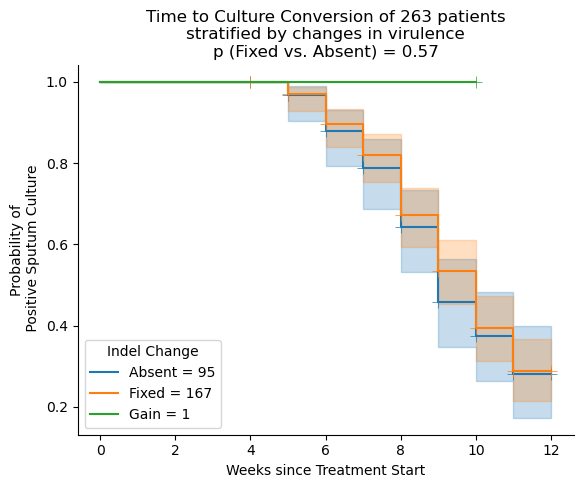

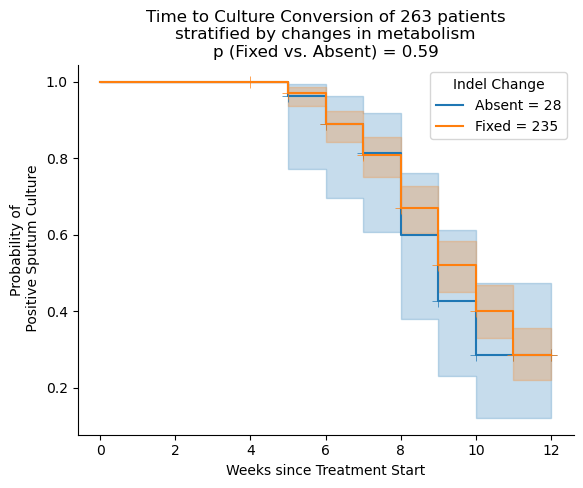

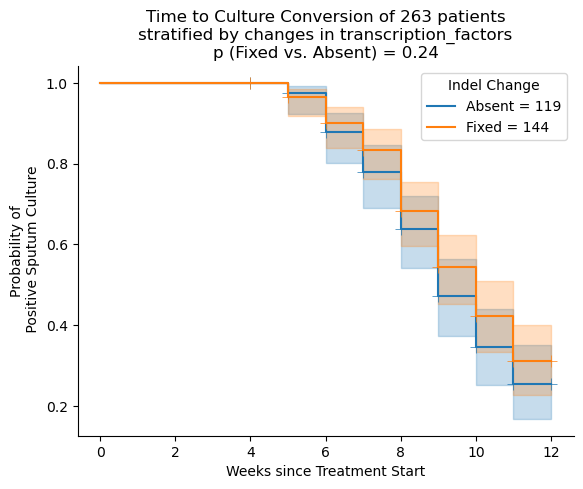

In [76]:
for i, row in df_TCC_results.query("pval <= 1 & covariate.str.contains('Indel')")[['covariate', 'Indel']].iterrows():
        
    df_plot_TCC = plot_survival_curve_by_indel(df_imputed_patient_data,
                                                   df_imputed_TCC,
                                                   'culture_convert',
                                                   'TCC',
                                                   row['Indel'], 
                                                   sample_1_variants_grouped_pathways, 
                                                   sample_2_variants_grouped_pathways, 
                                                   indels_difference_grouped_pathways, 
                                                   exclude_fixed_absent=False,
                                                   change_thresh=0.05, 
                                                   freq_thresh=5,
                                                   logrank_test_compare_groups=['Fixed', 'Absent'], 
                                                   colors_dict = {'Fixed': '#ff7f0e', 'Absent': '#1f77b4', 'Gain': '#2ca02c', 'Loss': '#d62728'},
                                                   p=0,
                                                   q=0
                                                  )
    
    print("\n")

In [171]:
df_TCC_results.query("pval <= 0.1 & covariate.str.contains('Indel')")[['covariate', 'Indel', 'pval', 'HR_TCC_assoc_lower', 'HR_TCC_assoc', 'HR_TCC_assoc_upper']]

,covariate,Indel,pval,HR_TCC_assoc_lower,HR_TCC_assoc,HR_TCC_assoc_upper
162,Indel_Sample1,Rv3527-Rv3528c_n.3964464delG,0.088141,6.213690e-02,2.746354e-01,1.213846
362,Indel_Sample1,mce2D,0.072811,1.758501e-01,4.357895e-01,1.079968
641,Indel_Change,Rv2437,0.092684,5.999430e-28,2.703138e-13,121.794132


In [218]:
# AF_change_thresh_plot = 0

# plot_AF_matrix = plot_AF_matrix.loc[(plot_AF_matrix[variant] > AF_change_thresh_plot) | (plot_AF_matrix[variant] < -AF_change_thresh_plot)]

# fig, ax = plt.subplots(figsize=(9, 4))

# # Loop through samples and draw arrows
# for i, row in plot_AF_matrix.iloc[::-1, :].iterrows():
#     ax.annotate(
#         '', xy=(row['Sample2'], row['pid']), xytext=(row['Sample1'], row['pid']),
#         arrowprops=dict(arrowstyle='->,head_length=0.5,head_width=0.3', color='steelblue', lw=2)
#     )
#     # add point markers for the AFs
#     ax.plot(row['Sample1'], row['pid'], 'o', color='gray', zorder=0, markersize=8, label='Sample 1')
#     ax.plot(row['Sample2'], row['pid'], 'o', color='black', zorder=0, markersize=8, label='Sample 2')

# # plt.axvline(0.05, color='darkred', linestyle='--', linewidth=0.8, label = '(0.05, 0.9]')
# # plt.axvline(0.90, color='darkred', linestyle='--', linewidth=0.8, label = '(0.05, 0.9]')
# ax.set_xlabel('Allele Frequency (AF)')
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
# ax.set_title(f'Longitudinal Changes in {variant}')
# # plt.grid(axis='x', linestyle='--', alpha=0.5)
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
# sns.despine()
# plt.tight_layout()
# # plt.show()
# plt.savefig(f"./results/figures/{variant}_within_sample_changes.svg")

# Do pids with espR Indel have higher Isoniazid MIC at baseline?

According to this paper they did: https://pmc.ncbi.nlm.nih.gov/articles/PMC11898584

In [ ]:
# which models to use for each drug
drug = 'INH'
CNN_results_dir = "/n/data1/hms/dbmi/farhat/Sanjana/CNN_results"
drug_lineage_inclusion_dict = {drug: 'lineage_amino_acid'}
df_pred = pd.read_csv(os.path.join(CNN_results_dir, f"{drug}_{drug_lineage_inclusion_dict[drug]}", "TRUST", "test_predictions.csv")).rename(columns={'ROLLINGDB_ID': 'SampleID', 'pred_MIC': f'{drug}_pred_MIC'})

# drop patient duplicates (because multiple WGS samples per pid)
df_pred = df_pred.merge(df_trust_patients[['SampleID', 'Original_ID', 'pid']]).sort_values(['pid', 'Original_ID']).drop_duplicates('pid', keep='first').reset_index(drop=True)

In [ ]:
def get_predicted_MICs_multiple_samplings(df_variants):

    multiple_samples_per_pid = pids_for_analysis[['pid', 'SampleID', 'Sampling_Week', 'Paired_Sample_Num', 'F2', 'Coll2014', 'Freschi2020', 'Lineage']].drop_duplicates()
    print(len(multiple_samples_per_pid), multiple_samples_per_pid.pid.nunique(), multiple_samples_per_pid.SampleID.nunique())

    drug_lineage_inclusion_dict = dict(zip(drugs_lst, ['lineage_amino_acid']*4))
    drug_lineage_inclusion_dict['PZA'] = 'amino_acid'
    
    for drug in drugs_lst:
        # which models to use for each drug
        assert drug_lineage_inclusion_dict[drug] in ['lineage_amino_acid', 'amino_acid']
        df_pred = pd.read_csv(os.path.join(CNN_results_dir, f"{drug}_{drug_lineage_inclusion_dict[drug]}", "TRUST", "test_predictions.csv")).rename(columns={'ROLLINGDB_ID': 'SampleID', 'pred_MIC': f'{drug}_pred_MIC'})

        # add MICs to the dataframe
        multiple_samples_per_pid = multiple_samples_per_pid.merge(df_pred[['SampleID', f'{drug}_pred_MIC']], on='SampleID')

    return multiple_samples_per_pid

In [49]:
multiple_samples_pred_MIC = get_predicted_MICs_multiple_samplings(df_variants)

592 296 592


In [50]:
multiple_samples_pred_MIC.pid.nunique(), multiple_samples_pred_MIC.SampleID.nunique()

(296, 592)

In [51]:
df_plot_outcome_with_MIC = df_plot_outcome.merge(multiple_samples_pred_MIC)
df_plot_outcome_with_MIC.pid.nunique()

258

In [52]:
# get all pids with the variant ever
variant = 'espR_c.-145_-144insG'

pids_with_variant_of_interest = list(set(sample_1_variants.loc[(sample_1_variants[variant] > 0.05)].index).union(sample_2_variants.loc[(sample_2_variants[variant] > 0.05)].index))

# keep only pids that are valid for the analysis (not using the demographic exclusion criteria, just genotypic)
TRUST_phenos = TRUST_phenos.query("pid in @low_F2_pids.pid")
df_pred_combined = df_pred_combined.query("pid in @low_F2_pids.pid")

TRUST_phenos['espR_indel'] = TRUST_phenos['pid'].isin(pids_with_variant_of_interest).astype(int)
df_pred_combined['espR_indel'] = df_pred_combined['pid'].isin(pids_with_variant_of_interest).astype(int)

TRUST_phenos.pid.nunique(), df_pred_combined.pid.nunique()

(274, 274)

In [53]:
st.mannwhitneyu(df_pred_combined.query("espR_indel==0")['INH_pred_MIC'],
                df_pred_combined.query("espR_indel==1")['INH_pred_MIC'],
                alternative='less'
               )

MannwhitneyuResult(statistic=1162.5, pvalue=0.059694333352609805)

In [54]:
st.mannwhitneyu(TRUST_phenos.query("espR_indel==0")['INH_midpoint'],
                TRUST_phenos.query("espR_indel==1")['INH_midpoint'],
                alternative='less'
               )

MannwhitneyuResult(statistic=1078.0, pvalue=0.012256522146201198)

# Composite Poor Outcomes

In [42]:
df_tx_outcomes = pd.read_csv("./patient_data/tx_outcomes_table.csv").query("pid in @pids_for_analysis.pid")#.query("pid in @low_F2_pids.pid")

print(f"Maximum event date: {df_tx_outcomes.weeks.max()} weeks")

Maximum event date: 99.0 weeks


In [43]:
df_imputed_patient_data_outcomes = pd.read_csv("./imputation/data_outcomes.csv").drop_duplicates()
df_TCC_imputed_all = pd.read_csv("imputation/TCC.csv").rename(columns={'culture_convert_imputed': 'culture_convert', 'TCC_imputed': 'TCC'})

# idk why this is, but when I include the HIV_CD4 variable in the imputation for the outcomes, mice doesn't converge, so I removed it
# and replaced it with bl_hiv and bl_cd4. So have to add HIV_CD4 in manually here
df_imputed_patient_data_outcomes.loc[(df_imputed_patient_data_outcomes['bl_hiv']==1) & (df_imputed_patient_data_outcomes['bl_cd4'] < 200), 'HIV_CD4'] = 2
df_imputed_patient_data_outcomes.loc[(df_imputed_patient_data_outcomes['bl_hiv']==1) & (df_imputed_patient_data_outcomes['bl_cd4'] >= 200), 'HIV_CD4'] = 1
df_imputed_patient_data_outcomes.loc[(df_imputed_patient_data_outcomes['bl_hiv']==0), 'HIV_CD4'] = 0

# do this to keep only patients with a valid TCC. The TCC longer than 8 weeks variable was part of the imputation, but don't want to use those imputed values.
df_imputed_patient_data_outcomes = df_imputed_patient_data_outcomes.merge(df_TCC_imputed_all.rename(columns={'imp_num': '.imp'}), on=['pid', '.imp'])
df_imputed_patient_data_outcomes['delayed_TCC'] = (df_imputed_patient_data_outcomes['TCC'] > 8).astype(int)

df_imputed_patient_data_outcomes.pid.nunique()

391

In [44]:
df_tx_outcomes.event.value_counts()

event
0    332
1     38
Name: count, dtype: int64

In [45]:
# 6 of these deaths were censored, so 35 - 6 = 29 above
df_tx_outcomes.event_type.value_counts()

event_type
cure          326
relapse        21
death          13
tx_failure     10
Name: count, dtype: int64

In [46]:
cols_lst = [
            'screen_sex',
            'screen_years',
            'bl_bmi', # numerical BMI
            'fstrom1_baseline', # smoking yes or no
            # 'smoked_substance_use',
            'HIV_CD4',
            'bl_prevtb',
            'smear_pos_no_contam_sputum_specimen_1', # binary variable for smear positivity at baseline
            'diabetes',
            'high_lung_involvement',
            'total_adherence',
            'cxr_cavity_chest_radiograph_1',
            # 'TTP',
            # 'underweight',
            'RIF_AUC',
            'INH_AUC',
            'EMB_AUC',
            'PZA_AUC',
            'delayed_TCC',
            'F2'
           ]

# try these first, as they were required for the full TCC model
stratify_covariates = [] #['smear_pos_no_contam_sputum_specimen_1', 'high_lung_involvement', 'cxr_cavity_chest_radiograph_1', 'screen_sex', 'HIV_CD4']
# non_linear_covariates = ['screen_years']

In [47]:
df_test_results, df_samples_imputations, cph_models_imputations = fit_cox_models_all_imputations(df_trust_patients,
                                                                                                  df_pred_combined,
                                                                                                   TRUST_phenos,
                                                                                                   df_imputed_patient_data_outcomes,
                                                                                                  df_tx_outcomes,
                                                                                                  cols_lst,
                                                                                                  event_col = 'event',
                                                                                                  time_col = 'date',
                                                                                                  exclude_resistance=False,
                                                                                                  MIC_type='none',
                                                                                                  binarize_MICs=False,
                                                                                                  tb_deaths_only=False,
                                                                                                  invert_OR=True,
                                                                                                  include_interactions=False,
                                                                                                  penalize_model=False,
                                                                                                  original_dataset_only=False,
                                                                                                  # cluster_col='household_num',#'unique_patient',
                                                                                                  stratify_variables=stratify_covariates,
                                                                                                  # non_linear_term_variables=non_linear_covariates,
                                                                                                 )

df_violating_covariates = []

for model_idx in range(len(cph_models_imputations)):

    df_proportional_hazards = lifelines.statistics.proportional_hazard_test(cph_models_imputations[model_idx], df_samples_imputations[model_idx], time_transform='rank').summary

    # diabetes has a p-value of like 0.0105
    violating_covariates = df_proportional_hazards.reset_index()[['index', 'p']].rename(columns={'index': 'covariate'})
    
    violating_covariates['imp_num'] = model_idx + 1

    df_violating_covariates.append(violating_covariates)

df_violating_covariates = pd.concat(df_violating_covariates)
df_violating_covariates.query("p <= 0.05")

    362 total pids


,covariate,p,imp_num
10,delayed_TCC,0.046917,11


In [50]:
# df_LRT_pvals_outcomes = pd.DataFrame(columns = ['pval'])

# for covar in cols_lst:

#     # need to stratify by these variables
#     if covar not in stratify_covariates:# and covar not in non_linear_covariates:

#         print(f"Testing {covar}")
    
#         pval = run_LRT_single_predictor(covar, 
#                                         df_trust_patients,
#                                         df_imputed_patient_data_outcomes,
#                                         df_imputed_patient_data_outcomes,
#                                         df_imputed_patient_data_outcomes, 
#                                         df_tx_outcomes, 
#                                         cols_lst, 
#                                         event_col='event',
#                                         time_col='date',
#                                         MIC_type='none',
#                                         stratify_variables=stratify_covariates,
#                                         # non_linear_term_variables=non_linear_covariates,
#                                        )
        
#         df_LRT_pvals_outcomes.loc[covar, 'pval'] = pval

# df_LRT_pvals_outcomes.reset_index().rename(columns={'index': 'covariate'}).to_csv("./results/outcomes/LRT_results_baseline_variants_only.csv", index=False)
# df_LRT_pvals_outcomes = pd.read_csv("./results/outcomes/LRT_results_baseline_variants_only.csv")
df_LRT_pvals_outcomes = pd.read_csv("/home/sak0914/MtbQuantCNN/analysis/TRUST/model_results/LRT_results_outcomes_TB_deaths_only.csv")

In [51]:
# df_LRT_pvals_outcomes.sort_values("pval")

In [52]:
final_patient_predictors = list(df_LRT_pvals_outcomes.query("pval <= 0.2").covariate.values) + stratify_covariates
final_patient_predictors

['HIV_CD4', 'diabetes', 'total_adherence', 'F2']

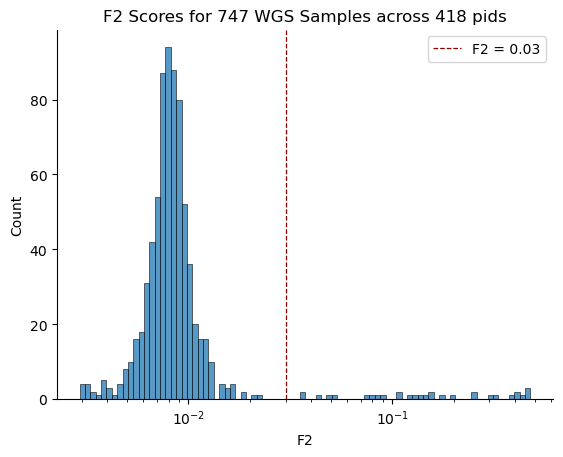

In [53]:
sns.histplot(data=pids_for_analysis,
             x='F2',
             log_scale=True
            )

plt.axvline(F2_thresh, color='darkred', linestyle='--', linewidth=0.9, label=f'F2 = {F2_thresh}')

plt.title(f"F2 Scores for {len(pids_for_analysis)} WGS Samples across {pids_for_analysis.pid.nunique()} pids")
plt.legend()
sns.despine()
plt.savefig("./results/figures/F2_distribution.svg", bbox_inches='tight')

# Check for violations of the proportional hazards assumption once we add AUCs and lineage variables

Add presence of resistance variants?

Not including INH resistance because all patients with INH resistance did not have an outcome, and the perfect separation causes numerical instability problems.

In [53]:
df_test_results, df_samples_imputations, cph_models_imputations = fit_cox_models_all_imputations(df_trust_patients,
                                                                                                  df_pred_combined,
                                                                                                   TRUST_phenos,
                                                                                                   df_imputed_patient_data_outcomes,
                                                                                                  df_tx_outcomes,
                                                                                                  final_patient_predictors + [ 'Lineage'],
                                                                                                  event_col = 'event',
                                                                                                  time_col = 'date',
                                                                                                  tb_deaths_only=True,
                                                                                                  invert_OR=False,
                                                                                                  stratify_variables=stratify_covariates,
                                                                                                 )

df_violating_covariates = []

for model_idx in range(len(cph_models_imputations)):

    df_proportional_hazards = lifelines.statistics.proportional_hazard_test(cph_models_imputations[model_idx], df_samples_imputations[model_idx], time_transform='rank').summary

    # diabetes has a p-value of like 0.0105
    violating_covariates = df_proportional_hazards.reset_index()[['index', 'p']].rename(columns={'index': 'covariate'})
    
    violating_covariates['imp_num'] = model_idx + 1

    df_violating_covariates.append(violating_covariates)

df_violating_covariates = pd.concat(df_violating_covariates)
df_violating_covariates.query("p <= 0.05")

    Censored 6 patients with non-TB deaths
    362 total pids


,covariate,p,imp_num


In [54]:
len(set(df_imputed_patient_data_outcomes.pid).intersection(df_tx_outcomes.pid).intersection(df_trust_patients.pid))

362

In [55]:
set(df_tx_outcomes.pid) - set(df_trust_patients.pid)

{'T0081', 'T0157', 'T0194', 'T0382', 'T0402', 'T0407', 'T0428', 'T0450'}

In [58]:
label_dict = {'RIF_AUC': 'Rifampicin PK AUC',
              'INH_AUC': 'Isoniazid PK AUC',
              'EMB_AUC': 'Ethambutol PK AUC',
              'PZA_AUC': 'Pyrazinamide PK AUC',
              'screen_sex': 'Sex',
              'screen_years': 'Age',
              'bl_bmi': 'Body Mass Index',
              'smoked_substance_use': 'Smoked Substance Use',
              'HIV_High_CD4': 'HIV, CD4 ≥ 200 cells/$\mathregular{mm^3}$',
              'HIV_Low_CD4': 'HIV, CD4 < 200 cells/$\mathregular{mm^3}$',
              'INH_midpoing': 'Measured INH MIC',
              'bl_prevtb': 'Previous TB Disease',
              'smear_pos_no_contam_sputum_specimen_1': 'Smear Positivity',
              'diabetes': 'Diabetes',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4',
              'total_adherence': 'Adherence Rate',
              'F2': 'F2 Strain Mixing Metric',
              'inh_resistant': 'INH Resistance',
              'high_lung_involvement': '>20% Lung Affected',
              'cxr_cavity_chest_radiograph_1': 'Cavitation',
              'fstrom1_baseline': 'Smoking',
              'Lineage_1': 'Lineage 1',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4'
             }

forest_plot(df_test_results, label_dict, val_col='OR', alpha=0.05, log=True, saveName=f"./results/figures/outcomes/patient_predictors.svg")

In [109]:
df_results_all_indels_outcomes = []

for variant in ['mammalian_cell_entry', 'esx', 'lipid_metabolism', 'other_metabolism', 'transcription_factors']: #sample_1_variants.columns: #: #sample_1_variants_grouped_pathways.columns: #gene_grouping_dict.keys(): #sample_1_variants_grouped_pathways.columns: #sample_1_variants.columns:

    print(f"Testing {variant}")
    
    # df_imputed_patient_data_single_variant = add_change_to_indel_to_patient_data(df_imputed_patient_data_outcomes, 
    #                                                                                  sample_1_variants_grouped_pathways,
    #                                                                                  sample_2_variants_grouped_pathways,
    #                                                                                  indels_difference_grouped_pathways,
    #                                                                                  variant,
    #                                                                                  freq_thresh=10,
    #                                                                                  include_interaction=False
    #                                                                                  )
    
    df_imputed_patient_data_single_variant = add_indel_at_baseline_to_patient_data(df_imputed_patient_data_outcomes,
                                                                                   sample_1_variants_grouped_pathways,
                                                                                   variant,
                                                                                   freq_thresh=10,
                                                                                  )
    

    # will be None if there are not enough patients with the specified change in the indel or the variant
    if df_imputed_patient_data_single_variant is not None:
                
#         pids_with_change = indels_difference_grouped_pathways.loc[(indels_difference_grouped_pathways[variant] >= 0.1) | (indels_difference_grouped_pathways[variant] <= -0.1)].index.values
        
#         # only include the Indel_Change variable if is at least 1 patient in each even / no event group with an AF change. Otherwise, you get perfect separation
#         # of the groups, and the hazard ratio estimates will be huge and unreliable
#         if df_tx_outcomes.query("pid in @pids_with_change").event.nunique() == 2:
#             # predictors_lst = final_patient_predictors + ['Lineage'] + ['Indel_Sample1', 'Indel_Change']
#             predictors_lst = ['Indel_Sample1', 'Indel_Change']
#         else:
#             # predictors_lst = final_patient_predictors + ['Lineage'] + ['Indel_Sample1']
#              predictors_lst = ['Indel_Sample1']
                
        # no inh_resistant because it perfectly separates the groups in many cases
        df_test_results_indel, _, _ = fit_cox_models_all_imputations(df_trust_patients,
                                                                     df_pred_combined,
                                                                     TRUST_phenos,
                                                                     df_imputed_patient_data_single_variant,
                                                                     df_tx_outcomes,
                                                                     final_patient_predictors + ['Lineage', 'Indel_Sample1'],
                                                                     event_col = 'event',
                                                                     time_col = 'date',
                                                                     tb_deaths_only=True,
                                                                     invert_OR=False,
                                                                     stratify_variables=stratify_covariates,
                                                                     )

        df_test_results_indel['Indel'] = variant    
        df_results_all_indels_outcomes.append(df_test_results_indel)


# fName = "./results/outcomes/indels_baseline_variants_only.csv"
fName = "./results/outcomes/indels_baseline_variants_only_grouped_pathways.csv"

# df_results_all_indels_outcomes = pd.concat(df_results_all_indels_outcomes)
# df_results_all_indels_outcomes.to_csv(fName, index=False)
df_results_all_indels_outcomes = pd.read_csv(fName)

Testing mammalian_cell_entry
    Censored 6 patients with non-TB deaths
    362 total pids
Testing esx
    Censored 6 patients with non-TB deaths
    362 total pids
Testing lipid_metabolism
    Censored 6 patients with non-TB deaths
    362 total pids
Testing other_metabolism
    Censored 6 patients with non-TB deaths
    362 total pids
Testing transcription_factors
    Censored 6 patients with non-TB deaths
    362 total pids


In [111]:
df_results_all_indels_outcomes.query("pval <= 0.05").covariate.unique()

array(['HIV_Low_CD4', 'Lineage_1', 'total_adherence'], dtype=object)

In [112]:
df_results_all_indels_outcomes.query("covariate=='Indel_Sample1'")

,covariate,coef_pooled,V_w,V_b,V_t,se_pooled,riv,wald_stat,dof_old,lambda,dof_observed,dof_adj,pval,t_critical,coef_lower,coef_upper,OR,OR_lower,OR_upper,Indel
3,Indel_Sample1,0.921388,0.441647,0.000007,0.441654,0.664571,0.000016,1.386440,1.157483e+11,0.000016,376.009796,376.009795,0.165613,1.959964,-0.381148,2.223923,2.512774,0.683077,9.243518,mammalian_cell_entry
12,Indel_Sample1,-0.591707,0.624983,0.000092,0.625078,0.790619,0.000153,-0.748409,1.243747e+09,0.000153,375.958331,375.958218,0.454213,1.959964,-2.141291,0.957878,0.553382,0.117503,2.606160,esx
21,Indel_Sample1,-0.292947,0.654948,0.000014,0.654962,0.809297,0.000022,-0.361977,5.884932e+10,0.000022,376.007401,376.007399,0.717369,1.959964,-1.879141,1.293247,0.746061,0.152721,3.644600,lipid_metabolism
30,Indel_Sample1,-0.145078,0.383857,0.000093,0.383953,0.619639,0.000249,-0.234132,4.677810e+08,0.000249,375.922125,375.921823,0.814882,1.959964,-1.359548,1.069393,0.864955,0.256777,2.913611,other_metabolism
39,Indel_Sample1,-0.826032,0.787704,0.000044,0.787750,0.887553,0.000058,-0.930685,8.525964e+09,0.000058,375.993818,375.993802,0.352016,1.959964,-2.565604,0.913539,0.437783,0.076873,2.493130,transcription_factors


In [68]:
def plot_survival_curve_by_indel_baseline(df_patient_data, df_outcome, event_variable, duration_variable, variant, sample_1_variants, exclude_fixed_absent=False, change_thresh=0.05, fixed_thresh=0.75, freq_thresh=5, logrank_test_compare_groups=['Gain', 'Loss'], colors_dict = {'Gain': '#1f77b4', 'Loss': '#ff7f0e', 'Fixed': '#d62728', 'Absent': '#2ca02c'}, p=0, q=0, save=False):

    if '.imp' in df_outcome.columns:
        df_outcome.rename(columns={'.imp': 'imp_num'}, inplace=True)
        
    if 'imp_num' not in df_outcome.columns:
        df_outcome['imp_num'] = 0
    
    df_imputed_patient_data_single_variant = add_indel_at_baseline_to_patient_data(df_patient_data, 
                                                                                 sample_1_variants, 
                                                                                 variant, 
                                                                                )

    if df_imputed_patient_data_single_variant is not None:

        # for variable in stratify_covariates:
        df_plot_outcome = df_outcome.query("imp_num==0").merge(df_imputed_patient_data_single_variant.loc[df_imputed_patient_data_single_variant['.imp']==0][['pid', 'Indel_Sample1']])

        df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] <= change_thresh), 'Group'] = 'Absent'
        df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] > change_thresh) & (df_plot_outcome['Indel_Sample1'] <= fixed_thresh), 'Group'] = 'Unfixed'
        df_plot_outcome.loc[(df_plot_outcome['Indel_Sample1'] > fixed_thresh), 'Group'] = 'Fixed'
        
        df_plot_outcome['Group'] = df_plot_outcome['Group'].replace('nan', np.nan)

        if sum(pd.isnull(df_plot_outcome['Group'])) > 0:
            print(df_plot_outcome.loc[pd.isnull(df_plot_outcome['Group'])])
            raise ValueError()

        fig, ax = plt.subplots()
                
        # sort so that 0 is plotted before 1
        for group in np.sort(df_plot_outcome['Group'].unique()):
            
            if not exclude_fixed_absent:
                df_single_group = df_plot_outcome.query("Group==@group")
                kmf = lifelines.KaplanMeierFitter()
                kmf.fit(df_single_group[duration_variable], event_observed=df_single_group[event_variable], label=group)
                kmf.plot_survival_function(ax=ax, color=colors_dict[group], show_censors=True, censor_styles={"marker": "+", "ms": 8, "mew": 0.5}, label=f"{group} = {len(df_single_group)}")
            else:
                if group not in ['Fixed', 'Absent']:
                    df_single_group = df_plot_outcome.query("Group==@group")
                    kmf = lifelines.KaplanMeierFitter()
                    kmf.fit(df_single_group[duration_variable], event_observed=df_single_group[event_variable], label=group)
                    kmf.plot_survival_function(ax=ax, color=colors_dict[group], show_censors=True, censor_styles={"marker": "+", "ms": 8, "mew": 0.5}, label=f"{group} = {len(df_single_group)}")            

        # weight = [S(t)]^p * [1 - S(t)]^q, where S(t) is the survival function. 
        # p = 1 and q = 1 weights the middle the most
        # p = 0 and q = 0 doesn't weight by the survival function
        logRank_test_full = lifelines.statistics.multivariate_logrank_test(event_durations=df_plot_outcome[duration_variable],
                                                                      groups=df_plot_outcome['Group'],
                                                                      event_observed=df_plot_outcome[event_variable],
                                                                      weightings='fleming-harrington',
                                                                      p = p, # p = 1 weights early times more
                                                                      q = q, # q = 1 weights late times more
                                                                     )
        
        assert len(logrank_test_compare_groups) == 2
        group_1, group_2 = logrank_test_compare_groups
        assert group_1 != group_2
        
        # p = 0 and q = 0 doesn't weight by the survival function
        logRank_test_2_groups = lifelines.statistics.multivariate_logrank_test(event_durations=df_plot_outcome.query("Group in @logrank_test_compare_groups")[duration_variable],
                                                                              groups=df_plot_outcome.query("Group in @logrank_test_compare_groups")['Group'],
                                                                              event_observed=df_plot_outcome.query("Group in @logrank_test_compare_groups")[event_variable],
                                                                              weightings='fleming-harrington',
                                                                              p = p, # p = 1 weights early times more
                                                                              q = q, # q = 1 weights late times more
                                                                             )

        print(f"{variant}: χ^2 = {logRank_test_full.test_statistic}, p = {logRank_test_full.p_value}")

        plt.xlabel("Weeks since Treatment Start")
        sns.despine()
        plt.legend(title='Indel State')        
        
        if duration_variable == 'TCC':
            plt.title(f"Time to Culture Conversion of {df_plot_outcome.pid.nunique()} patients\nstratified by changes in {variant}\np ({group_1} vs. {group_2}) = {np.round(logRank_test_2_groups.p_value, 2)}")
            plt.ylabel("Probability of\n Positive Sputum Culture") #
            
            if save:
                plt.savefig(f"./results/figures/TCC/{variant}_KM_curve.svg", bbox_inches='tight')
            else:
                plt.show()
                
        else:
            plt.ylabel("Probability of No Event")
            plt.title(f"Time to Unfavorable Outcomes of {df_plot_outcome.pid.nunique()} patients\nstratified by changes in {variant}\np ({group_1} vs. {group_2}) = {np.round(logRank_test_2_groups.p_value, 2)}")
            
            if save:
                plt.savefig(f"./results/figures/outcomes/{variant}_KM_curve.svg", bbox_inches='tight')
            else:
                plt.show()

        return df_plot_outcome

esx: χ^2 = 14.595680753989205, p = 0.0006769992607552614




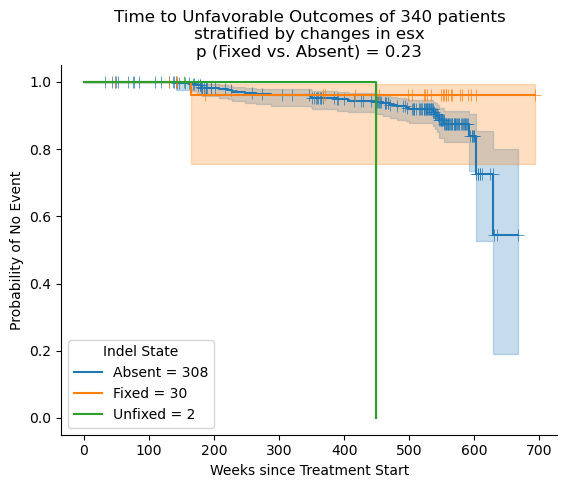

In [116]:
variant = 'esx'

pids_with_variant = sample_1_variants_grouped_pathways.loc[(sample_1_variants_grouped_pathways[variant] <= 0.75) & (sample_1_variants_grouped_pathways[variant] >= 0.05)].index.values

df_plot_outcome = plot_survival_curve_by_indel_baseline(df_imputed_patient_data_outcomes.query("pid not in @high_F2_pids.pid.values"),
                                                       df_tx_outcomes.query("pid in @df_trust_patients.pid"), # require this to exclude pid T0402 which has discordant WGS
                                                       'event',
                                                       'date',
                                                       variant,
                                                       sample_1_variants_grouped_pathways, 
                                                       exclude_fixed_absent=False,
                                                       change_thresh=0.05, 
                                                       freq_thresh=5,
                                                       logrank_test_compare_groups=['Fixed', 'Absent'], 
                                                       colors_dict = {'Fixed': '#ff7f0e', 'Absent': '#1f77b4', 'Unfixed': '#2ca02c', 'Loss': '#d62728'},
                                                       p=0,
                                                       q=0,
                                                       save=True
                                                      )

print("\n")

Rv0759c_c.-97_-96delGG: χ^2 = 9.542945791834331, p = 0.008467898636888313


PE_PGRS60: χ^2 = 4.007818429216499, p = 0.04528971639536179




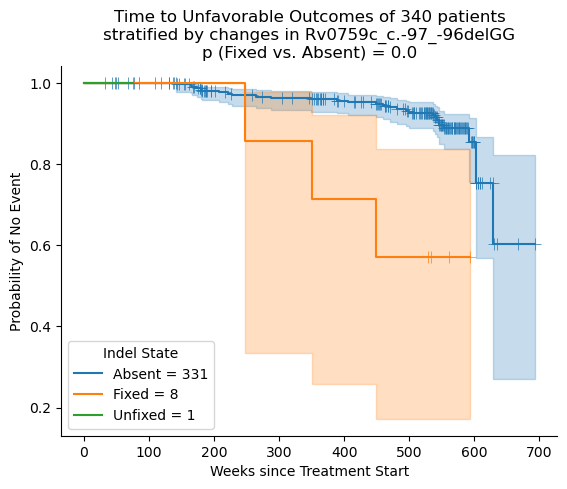

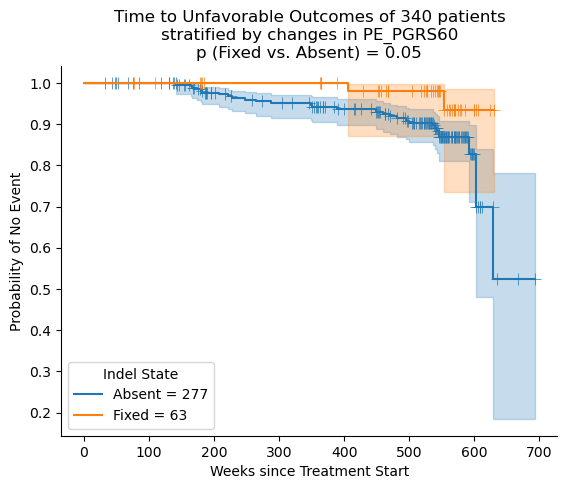

In [87]:
for i, row in df_results_all_indels_outcomes.query("pval <= 0.05 & covariate.str.contains('Indel')")[['covariate', 'Indel', 'OR_lower', 'OR', 'OR_upper']].iterrows():
    
    variant = row['Indel']
    
    pids_with_variant = sample_1_variants.loc[(sample_1_variants[variant] <= 0.75) & (sample_1_variants[variant] >= 0.05)].index.values
        
    df_plot_outcome = plot_survival_curve_by_indel_baseline(df_imputed_patient_data_outcomes.query("pid not in @high_F2_pids.pid.values"),
                                                           df_tx_outcomes.query("pid in @df_trust_patients.pid"), # require this to exclude pid T0402 which has discordant WGS
                                                           'event',
                                                           'date',
                                                           variant,
                                                           sample_1_variants, 
                                                           exclude_fixed_absent=False,
                                                           change_thresh=0.05, 
                                                           freq_thresh=5,
                                                           logrank_test_compare_groups=['Fixed', 'Absent'], 
                                                           colors_dict = {'Fixed': '#ff7f0e', 'Absent': '#1f77b4', 'Unfixed': '#2ca02c', 'Loss': '#d62728'},
                                                           p=0,
                                                           q=0,
                                                           save=True
                                                          )

    print("\n")

In [88]:
variant = 'PE_PGRS60'

label_dict = {'RIF_AUC': 'Rifampicin PK AUC',
              'INH_AUC': 'Isoniazid PK AUC',
              'EMB_AUC': 'Ethambutol PK AUC',
              'PZA_AUC': 'Pyrazinamide PK AUC',
              'screen_sex': 'Sex',
              'screen_years': 'Age',
              'bl_bmi': 'Body Mass Index',
              'smoked_substance_use': 'Smoked Substance Use',
              'HIV_High_CD4': 'HIV, CD4 ≥ 200 cells/$\mathregular{mm^3}$',
              'HIV_Low_CD4': 'HIV, CD4 < 200 cells/$\mathregular{mm^3}$',
              'INH_midpoing': 'Measured INH MIC',
              'bl_prevtb': 'Previous TB Disease',
              'smear_pos_no_contam_sputum_specimen_1': 'Smear Positivity',
              'diabetes': 'Diabetes',
              'Indel_Change': f'{variant} Gain',
              'Indel_Sample1': f'Frameshift in {variant}',
              'Indel_Sample1_x_Change': f'{variant} at Baseline x Gain',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4',
              'total_adherence': 'Adherence Rate',
              'F2': 'F2 Strain Mixing Metric',
              'inh_resistant': 'INH Resistance',
              'high_lung_involvement': '>20% Lung Affected',
              'cxr_cavity_chest_radiograph_1': 'Cavitation',
              'fstrom1_baseline': 'Smoking',
              'Lineage_1': 'Lineage 1',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4'
             }

forest_plot(df_results_all_indels_outcomes.query("Indel==@variant"), label_dict, val_col='OR', alpha=0.05, log=True, saveName=f"./results/figures/outcomes/{variant}_forest_plot.svg")

In [90]:
variant = 'Rv0759c_c.-97_-96delGG'

label_dict = {'RIF_AUC': 'Rifampicin PK AUC',
              'INH_AUC': 'Isoniazid PK AUC',
              'EMB_AUC': 'Ethambutol PK AUC',
              'PZA_AUC': 'Pyrazinamide PK AUC',
              'screen_sex': 'Sex',
              'screen_years': 'Age',
              'bl_bmi': 'Body Mass Index',
              'smoked_substance_use': 'Smoked Substance Use',
              'HIV_High_CD4': 'HIV, CD4 ≥ 200 cells/$\mathregular{mm^3}$',
              'HIV_Low_CD4': 'HIV, CD4 < 200 cells/$\mathregular{mm^3}$',
              'INH_midpoing': 'Measured INH MIC',
              'bl_prevtb': 'Previous TB Disease',
              'smear_pos_no_contam_sputum_specimen_1': 'Smear Positivity',
              'diabetes': 'Diabetes',
              'Indel_Change': f'{variant} Gain',
              'Indel_Sample1': f'{variant}',
              'Indel_Sample1_x_Change': f'{variant} at Baseline x Gain',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4',
              'total_adherence': 'Adherence Rate',
              'F2': 'F2 Strain Mixing Metric',
              'inh_resistant': 'INH Resistance',
              'high_lung_involvement': '>20% Lung Affected',
              'cxr_cavity_chest_radiograph_1': 'Cavitation',
              'fstrom1_baseline': 'Smoking',
              'Lineage_1': 'Lineage 1',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4'
             }

forest_plot(df_results_all_indels_outcomes.query("Indel==@variant"), label_dict, val_col='OR', alpha=0.05, log=True, saveName=f"./results/figures/outcomes/{variant}_forest_plot.svg")



In [99]:
pids_with_variant = list(set(sample_1_variants.loc[sample_1_variants[variant] > 0].index.values).intersection(df_tx_outcomes.pid))

df_trust_patients.query("pid in @pids_with_variant")[['pid', 'Lineage', 'inh_resistant']]

,pid,Lineage,inh_resistant
45,T0049,4.0,0.0
71,T0077,4,0.0
91,T0106,4,0.0
94,T0110,4,0.0
109,T0125,4,0.0
130,T0149,4,0.0
182,T0205,4,0.0
193,T0217,2.0,0.0
229,T0257,4,0.0


In [104]:
non_coding_regions = h37Rv_regions.query("Feature != 'CDS'").Name.values

In [108]:
df_variants.query("GENE in @non_coding_regions").drop_duplicates(subset=['variant', 'pid']).variant.value_counts()

variant
F6_n.30dupC       317
mcr11_n.95delC    220
Name: count, dtype: int64

In [138]:
4094527-4093940

587

In [91]:
PE_PGRS60_start = h37Rv_genes.query("Symbol == 'PE_PGRS60'").Start.values[0]
PE_PGRS60_end = h37Rv_genes.query("Symbol == 'PE_PGRS60'").End.values[0]

In [123]:
PE_PGRS60_AA = h37Rv_seq.seq[PE_PGRS60_start-1:PE_PGRS60_end].translate()

# delete G at 4093880
del_pos = 4093880

# skip the deletion position
PE_PGRS60_frameshifted_NT = h37Rv_seq.seq[PE_PGRS60_start-1:del_pos-1] + h37Rv_seq.seq[del_pos:]
PE_PGRS60_frameshifted_AA = PE_PGRS60_frameshifted_NT.translate()

# PE_PGRS60 is 104 AA long, and PE_PGRS61 is 195 AA long. The frameshifted protein would terminate at 221 AA long, which is 74% of the length
stop_codon_pos = PE_PGRS60_frameshifted_AA.find("*")
stop_codon_pos

221

In [136]:
PE_PGRS60_frameshifted_AA[:stop_codon_pos]

Seq('MSYVIAAPEALVAAATDLATLGSTIGAANAAAAGSTTALLTAGADEVSAAIAAY...VGR')

In [133]:
# in Mtb 18B assembly, they are one ORF, which is 306 AA long
Mtb_18B_PE_PGRS6061_NT = Seq.Seq("gtgtccgatgtcatatgtgatcgcggcgccggaggcgctggtggcggcggccacggatttggctactctcggctcgacgatcggcgccgccaacgcggccgctgcgggctcgacaacggcgttgctgaccgccggcgccgacgaagtgtcggcggcgatagcggcctattcggaatgcacggccagacctatcaggcactcagtgcgcgggcggcggcgttccatgagcggttcgtgcaggccttggccacaggtgggggcgcctatgcggccgccgaggccgccagcgtctcgccgctgcagagcgcgctcgatttgctgaatgcgcccactcaggcgctgttggggcgtccgttggtgggcaatggcgccaatggggccccggggactggggcaaacggcggcgatggcgggattttgttcgggtccgggggggccggcgggtccggagcggccggcatggcgggtggcaacggcggggccgccgggctgttcggcaacggcggagccggcggagccggcggcagcgcgacggccggtgcggccggggcgggcgggaacggcggggccggcgggctgctgttcggtaccgccggggccggcggcaacggcgggttaagcctcggtttgggcgtcgccggcggcgccggcggcgccggcgggtcgggcggtagtgacaccgccggacacggggggaccggtggtgccggcggcctgctattcggcgccggcggcgccggcggcgccggcgaggacggcacaacgcccggtggcaacggtggggcgggcggtgtcgccgggctgttcggcgacggcggcaacggtggtaacgccggagttggcacgcccgcgggcaacgtcggcgccggcggcaccggcggcctgctgctcggccaggacggcatgaccgggttgacgtag")

Mtb_18B_PE_PGRS6061_AA = Mtb_18B_PE_PGRS6061_NT.translate()

In [134]:
Mtb_18B_PE_PGRS6061_AA

Seq('VSDVICDRGAGGAGGGGHGFGYSRLDDRRRQRGRCGLDNGVADRRRRRSVGGDS...LT*')

In [137]:
len(Mtb_18B_PE_PGRS6061_AA)

307

In [109]:
h37Rv_seq.seq[PE_PGRS60_start-1:del_pos-1] + Seq.Seq('A')

Seq('ATGTCATATGTGATCGCGGCGCCGGAGGCGCTGGTGGCGGCGGCCACGGATTTG...GTA')

In [104]:
h37Rv_seq.seq[PE_PGRS60_start-1:4093879]

Seq('ATGTCATATGTGATCGCGGCGCCGGAGGCGCTGGTGGCGGCGGCCACGGATTTG...GGT')

In [ ]:
h37Rv_seq.seq[PE_PGRS60_start-1:4093879]

In [100]:
h37Rv_seq[4093880-1]

'G'

In [97]:
PE_PGRS60_AA

Seq('MSYVIAAPEALVAAATDLATLGSTIGAANAAAAGSTTALLTAGADEVSAAIAAY...IC*')

In [99]:
df_variants.query("GENE=='PE_PGRS60'")

,pid,SampleID,POS,REF,ALT,QUAL,DP,DPB,RO,AO,...,variant,SRP_prob,SAP_prob,HT,Diff_NT,Unique_Change_NT,Phase_Variant,SNP,Sampling_Week,Paired_Sample_Num
9,T0001,MFS-331,4093879,TG,T,7245.65,240,213.333,0,240.0,...,PE_PGRS60_p.Ala85fs,NaN,0.059222,1,G,1.0,1,0,1.0,1
22,T0002,MFS-509,4093879,TG,T,7021.44,232,206.333,0,232.0,...,PE_PGRS60_p.Ala85fs,NaN,0.005229,1,G,1.0,1,0,1.0,1
34,T0002,MFS-510,4093879,TG,T,6089.29,202,179.556,0,202.0,...,PE_PGRS60_p.Ala85fs,NaN,0.150896,1,G,1.0,1,0,5.0,2
638,T0013,MFS-6,4093879,TG,T,8012.36,265,235.667,0,265.0,...,PE_PGRS60_p.Ala85fs,NaN,0.005389,1,G,1.0,1,0,9.0,2
674,T0016,MFS-519,4093879,TG,T,6214.21,206,183.111,0,206.0,...,PE_PGRS60_p.Ala85fs,NaN,0.001863,1,G,1.0,1,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19898,T0437,MFS-702,4093879,TG,T,6608.17,219,194.667,0,219.0,...,PE_PGRS60_p.Ala85fs,NaN,0.073296,1,G,1.0,1,0,1.0,1
19912,T0437,MFS-819,4093879,TG,T,6288.74,180,160.111,0,178.0,...,PE_PGRS60_p.Ala85fs,NaN,0.377552,1,G,1.0,1,0,5.0,2
20225,T0444,MFS-707,4093879,TG,T,2636.85,287,266.333,101,186.0,...,PE_PGRS60_p.Ala85fs,0.334828,0.022356,1,G,1.0,1,0,1.0,1
20612,T0452,MFS-714,4093879,TG,T,6932.99,231,205.333,0,230.0,...,PE_PGRS60_p.Ala85fs,NaN,0.000883,1,G,1.0,1,0,1.0,1


In [112]:
df_variants.query("variant==@variant").Lineage.value_counts()

Lineage
4.0    18
4       2
2.0     1
2.0     1
Name: count, dtype: int64

In [113]:
df_variants.query("variant==@variant").Coll2014.value_counts()

Coll2014
4.1.1.1    14
4.1.2.1     2
4.1.1.3     2
4.1         2
2.2.1.1     2
Name: count, dtype: int64

In [117]:
df_variants.query("variant==@variant & AF <= 0.75")[['pid', 'SampleID', 'F2', 'POS', 'REF', 'ALT', 'DP', 'AO', 'AF']]

,pid,SampleID,F2,POS,REF,ALT,DP,AO,AF
21578,T0217,MFS-758,0.011056,854252,GCC,G,290,173.0,0.596552


In [120]:
df_variants.query("variant==@variant & pid=='T0217'")[['pid', 'SampleID', 'F2', 'POS', 'REF', 'ALT', 'DP', 'AO', 'AF', 'Sampling_Week', 'Paired_Sample_Num']].sort_values('Paired_Sample_Num')

,pid,SampleID,F2,POS,REF,ALT,DP,AO,AF,Sampling_Week,Paired_Sample_Num
21578,T0217,MFS-758,0.011056,854252,GCC,G,290,173.0,0.596552,1,1
9802,T0217,MFS-759,0.011409,854252,GCC,G,231,174.0,0.753247,5,2


In [121]:
df_tx_outcomes.query("pid=='T0217'")

,pid,date,event_type,to_studyto_treatment_outcome,esp_reason_end_of_study_parti,esp_reasonoth_end_of_study_parti,esp_date_end_of_study_parti,waiver_reason_end_of_study_parti,esp_cod_end_of_study_parti,waiver_deathcause_end_of_study_parti,TB_death,event,reenroll,unique_patient,weeks,months,imp_num
180,T0217,76.0,cure,3.0,7.0,NaN,217.0,NaN,NaN,NaN,NaN,0,0,227,10.857143,2.533333,0


In [129]:
df_trust_patients.columns[df_trust_patients.columns.str.contains('comment', case=False)]

Index(['Comment', 'comment', 'inh_dst_comment_sputum_specimen_13',
       'rif_dst_comment_sputum_specimen_13', 'to_comments_treatment_outcome',
       'dna_comments_dna_extract_1', 'dna_comments_dna_extract_2'],
      dtype='object')

In [132]:
df_trust_patients.query("pid=='T0217'")[['to_comments_treatment_outcome', 'comment']].to_comments_treatment_outcome.values

array(['Verbal confirmation from Sr at TB Clinic that patient is regarded as "Treatment Defaulted" as she was loss to follow-up (no treatment received for more than two months). Did not finish TB Treatment.',
       'Verbal confirmation from Sr at TB Clinic that patient is regarded as "Treatment Defaulted" as she was loss to follow-up (no treatment received for more than two months). Did not finish TB Treatment.'],
      dtype=object)

In [68]:
sample_1_variants.loc[(sample_1_variants['PE_PGRS60'] <= 0.75) & (sample_1_variants['PE_PGRS60'] > 0)]['PE_PGRS60']

T0444    0.648084
T0087    0.404167
T0072    0.400901
T0066    0.059524
T0311    0.323404
T0305    0.525773
T0267    0.213953
Name: PE_PGRS60, dtype: float64

In [53]:
df_variants.query("GENE=='PE_PGRS60'")[['POS', 'REF', 'ALT', 'variant']].drop_duplicates()

,POS,REF,ALT,variant
9,4093879,TG,T,PE_PGRS60_p.Ala85fs


In [57]:
df_variants.query("GENE=='PE_PGRS60'").sort_values("SampleID")[['pid', 'SampleID', 'SAF', 'SAR', 'SAP_prob']]

,pid,SampleID,SAF,SAR,SAP_prob
892,T0021,MFS-10,70.0,142.0,0.000002
8288,T0186,MFS-104,83.0,94.0,0.355243
8301,T0186,MFS-105,61.0,84.0,0.080679
8400,T0188,MFS-106,72.0,97.0,0.078688
8687,T0196,MFS-111,97.0,99.0,0.494923
...,...,...,...,...,...
20126,T0452,MFS-831,93.0,102.0,0.406228
879,T0021,MFS-9,63.0,97.0,0.013492
7715,T0171,MFS-90,98.0,143.0,0.007488
7768,T0173,MFS-91,74.0,116.0,0.004819


In [146]:
for variant in df_results_all_indels_outcomes.query("pval <= 0.05 & covariate.str.contains('Indel')").Indel.values:
    
    pids_with_variant = sample_1_variants.loc[sample_1_variants[variant]==1].index.values
    
    print(variant, pids_with_variant)

fhaB_c.-36delG ['T0187' 'T0233' 'T0272' 'T0380' 'T0384']
Rv0759c_c.-97_-96delGG ['T0049' 'T0077' 'T0091' 'T0106' 'T0125' 'T0149' 'T0205' 'T0257' 'T0330']
Rv3128c_c.-139_-140insCC,Rv3129_c.-340_-339insCC ['T0187' 'T0233' 'T0272' 'T0380' 'T0384']
Rv0192 ['T0187' 'T0233' 'T0272' 'T0380' 'T0384']
Rv1215c ['T0049' 'T0091' 'T0149' 'T0205' 'T0257' 'T0330']
PE_PGRS31 ['T0049' 'T0091' 'T0149' 'T0205' 'T0257' 'T0330']
mce3B ['T0187' 'T0233' 'T0272' 'T0380' 'T0384']
ahpD ['T0049' 'T0091' 'T0149' 'T0205' 'T0257' 'T0330']


In [ ]:
# ['T0049' 'T0091' 'T0149' 'T0205' 'T0257' 'T0330'] have the variants in
# Rv0759c_c.-97_-96delGG, Rv1215c, PE_PGRS31, and ahpD

In [199]:
pids_with_same_variants = ['T0049', 'T0091', 'T0149', 'T0205', 'T0257', 'T0330']
sample_1_variants.loc[pids_with_same_variants, ['Rv0759c_c.-97_-96delGG', 'Rv1215c', 'PE_PGRS31', 'ahpD']]

,Rv0759c_c.-97_-96delGG,Rv1215c,PE_PGRS31,ahpD
T0049,1.0,1.0,1.0,1.0
T0091,1.0,1.0,1.0,1.0
T0149,1.0,1.0,1.0,1.0
T0205,1.0,1.0,1.0,1.0
T0257,1.0,1.0,1.0,1.0
T0330,1.0,1.0,1.0,1.0


In [202]:
df_variants.query("pid in @pids_with_same_variants").drop_duplicates(subset='pid').Coll2014.value_counts()

Coll2014
4.1.1.1    6
Name: count, dtype: int64

In [208]:
pids_for_analysis.query("pid in @pids_with_same_variants").columns

Index(['pid', 'Original_ID', 'SampleID', 'SampleLib', 'Pacbio', 'Comment',
       'quality', 'Cov_Any_Mean', 'Cov_Unam_Perc', 'Perc_Reads_Mapped',
       ...
       'last_dots_date', 'F2', 'Coll2014', 'Freschi2020', 'Lineage',
       'Sampling_Week', 'Paired_Sample_Num', 'Kraken_Unclassified_Percent',
       'high_F2', 'pid_high_F2'],
      dtype='object', length=7106)

In [209]:
df_variants

,pid,SampleID,Sampling_Week,Paired_Sample_Num,POS,REF,ALT,QUAL,DP,DPB,...,SAP_prob,F2,Lineage,Coll2014,HT,variant,Diff_NT,Unique_Change_NT,Phase_Variant,SNP


In [204]:
df_variants.query("pid in @pids_with_same_variants & GENE=='Rv1215c'")

,pid,SampleID,Sampling_Week,Paired_Sample_Num,POS,REF,ALT,QUAL,DP,DPB,...,SAP_prob,F2,Lineage,Coll2014,HT,variant,Diff_NT,Unique_Change_NT,Phase_Variant,SNP
1980,T0049,MFS-28,1,1,1358906,AC,A,4917.45,163,142.750,...,0.017710,0.008670,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
1999,T0049,MFS-29,8,2,1358906,AC,A,5206.87,173,152.000,...,0.001436,0.008782,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
3838,T0091,MFS-564,1,1,1358906,AC,A,5851.90,193,169.625,...,0.099031,0.008389,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
3857,T0091,MFS-736,5,2,1358906,AC,A,13423.00,378,330.750,...,0.000507,0.007203,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
5433,T0149,MFS-604,1,1,1358906,AC,A,6332.03,210,184.125,...,0.087408,0.004925,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
5452,T0149,MFS-605,5,2,1358906,AC,A,7032.67,234,204.750,...,0.116479,0.012019,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
7523,T0205,MFS-633,1,1,1358906,AC,A,6545.98,216,189.625,...,0.046723,0.006866,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
7542,T0205,MFS-634,4,2,1358906,AC,A,6031.56,201,176.125,...,0.002521,0.005875,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
9549,T0257,MFS-174,1,1,1358906,AC,A,6036.97,200,175.125,...,0.003953,0.008193,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0
9568,T0257,MFS-175,7,2,1358906,AC,A,7561.74,253,222.250,...,0.004186,0.008737,4,4.1.1.1,1,Rv1215c_p.Val180fs,C,1.0,1,0


In [184]:
# variant = 'mce3B'
variant = 'Rv0759c_c.-97_-96delGG'
pids_with_variant = sample_1_variants.loc[sample_1_variants[variant]==1].index.values

In [186]:
df_variants.query("pid in @pids_with_variant & variant==@variant")

,pid,SampleID,Sampling_Week,Paired_Sample_Num,POS,REF,ALT,QUAL,DP,DPB,...,SAP_prob,F2,Lineage,Coll2014,HT,variant,Diff_NT,Unique_Change_NT,Phase_Variant,SNP
1979,T0049,MFS-28,1,1,854252,GCC,G,6549.16,216,183.000,...,0.163079,0.008670,4,4.1.1.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
1998,T0049,MFS-29,8,2,854252,GCC,G,6775.09,223,188.923,...,0.381194,0.008782,4,4.1.1.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
3248,T0077,MFS-43,1,1,854252,GCC,G,8375.10,275,232.769,...,0.491884,0.021399,4,4.1.2.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
3268,T0077,MFS-44,6,2,854252,GCC,G,5893.26,196,165.846,...,0.344976,0.021498,4,4.1.2.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
3837,T0091,MFS-564,1,1,854252,GCC,G,8819.64,293,247.923,...,0.500000,0.008389,4,4.1.1.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
3856,T0091,MFS-736,5,2,854252,GCC,G,17246.30,481,407.077,...,0.495344,0.007203,4,4.1.1.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
4097,T0106,MFS-56,1,1,854252,GCC,G,7749.28,255,215.923,...,0.096119,0.018698,4,4.1.1.3,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
4117,T0106,MFS-57,8,2,854252,GCC,G,9041.80,297,251.308,...,0.307377,0.017603,4,4.1.1.3,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
4729,T0125,MFS-588,1,1,854252,GCC,G,9804.43,323,274.000,...,0.493082,0.023414,4,4.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0
4746,T0125,MFS-589,8,2,854252,GCC,G,7167.30,237,200.538,...,0.179322,0.020902,4,4.1,1,Rv0759c_c.-97_-96delGG,CC,1.0,1,0


In [187]:
df_tx_outcomes.query("pid in @pids_with_variant")

,pid,date,event_type,to_studyto_treatment_outcome,esp_reason_end_of_study_parti,esp_reasonoth_end_of_study_parti,esp_date_end_of_study_parti,waiver_reason_end_of_study_parti,esp_cod_end_of_study_parti,waiver_deathcause_end_of_study_parti,TB_death,event,reenroll,unique_patient,weeks,months,imp_num
39,T0049,449.0,relapse,2.0,5.0,NaN,449.0,NaN,NaN,NaN,NaN,1,0,21,64.142857,14.966667,0
63,T0077,534.0,cure,1.0,1.0,NaN,534.0,NaN,NaN,NaN,NaN,0,0,118,76.285714,17.800000,0
83,T0106,529.0,cure,1.0,1.0,NaN,529.0,NaN,NaN,NaN,NaN,0,0,140,75.571429,17.633333,0
99,T0125,593.0,cure,1.0,1.0,NaN,593.0,NaN,NaN,NaN,NaN,0,0,153,84.714286,19.766667,0
118,T0149,561.0,cure,1.0,1.0,NaN,561.0,NaN,NaN,NaN,NaN,0,0,172,80.142857,18.700000,0
170,T0205,84.0,cure,9.0,3.0,NaN,84.0,NaN,NaN,NaN,NaN,0,0,219,12.000000,2.800000,0
210,T0257,350.0,relapse,1.0,5.0,NaN,350.0,1.0,NaN,NaN,NaN,1,1,5,50.000000,11.666667,0


In [193]:
df_pred_combined.query("pid in @pids_with_variant")

,pid,RIF_pred_MIC,INH_pred_MIC,EMB_pred_MIC,PZA_pred_MIC
44,T0049,0.064936,0.049973,0.919206,24.936594
69,T0077,0.060977,0.050339,1.280068,24.756018
82,T0091,0.065054,3.285629,0.919206,24.936594
91,T0106,0.064164,0.051246,1.326902,24.936594
109,T0125,0.061919,0.050146,1.237477,25.042257
130,T0149,0.064936,0.049973,0.919206,24.936594
183,T0205,0.064936,0.049973,0.919206,24.936594
230,T0257,0.064936,0.049973,0.919206,24.936594
290,T0330,0.064936,0.049973,0.919206,24.936594


In [194]:
TRUST_phenos.query("pid in @pids_with_variant")

,pid,RIF_lower_bound,RIF_upper_bound,RIF_midpoint,INH_lower_bound,INH_upper_bound,INH_midpoint,EMB_lower_bound,EMB_upper_bound,EMB_midpoint,PZA_lower_bound,PZA_upper_bound,PZA_midpoint
241,T0091,0.030,0.060,0.0450,0.100,0.20,0.1500,0.6,1.25,0.925,NaN,NaN,NaN
2092,T0125,0.060,0.125,0.0925,0.025,0.05,0.0375,0.6,1.25,0.925,NaN,NaN,NaN
2175,T0149,0.125,0.250,0.1875,0.025,0.05,0.0375,0.6,1.25,0.925,25.0,50.0,37.5
2410,T0205,0.060,0.125,0.0925,0.025,0.05,0.0375,0.0,0.60,0.300,NaN,NaN,NaN
2539,T0330,0.060,0.125,0.0925,0.025,0.05,0.0375,0.6,1.25,0.925,0.0,25.0,12.5
3777,T0077,0.060,0.125,0.0925,0.025,0.05,0.0375,0.0,0.60,0.300,0.0,25.0,12.5
3860,T0049,0.125,0.250,0.1875,0.025,0.05,0.0375,0.6,1.25,0.925,NaN,NaN,NaN
4216,T0106,0.060,0.125,0.0925,0.025,0.05,0.0375,0.6,1.25,0.925,0.0,25.0,12.5
4457,T0257,0.060,0.125,0.0925,0.025,0.05,0.0375,0.6,1.25,0.925,25.0,50.0,37.5


In [155]:
df_variants.query("pid in ['T0049', 'T0091', 'T0149', 'T0205', 'T0257', 'T0330']").Coll2014.unique()

array(['4.1.1.1'], dtype=object)

In [152]:
df_variants.query("pid=='T0049' & GENE.str.contains('|'.join(['Rv0759c', 'Rv1215c', 'PE_PGRS31', 'ahpD']))")[['pid', 'SampleID', 'POS', 'REF', 'ALT', 'variant', 'Lineage']]

,pid,SampleID,POS,REF,ALT,variant,Lineage
1979,T0049,MFS-28,854252,GCC,G,Rv0759c_c.-97_-96delGG,4
1980,T0049,MFS-28,1358906,AC,A,Rv1215c_p.Val180fs,4
1984,T0049,MFS-28,2001878,CG,C,PE_PGRS31_p.Gly424fs,4
1988,T0049,MFS-28,2726815,GA,G,ahpD_p.Lys5fs,4
1998,T0049,MFS-29,854252,GCC,G,Rv0759c_c.-97_-96delGG,4
1999,T0049,MFS-29,1358906,AC,A,Rv1215c_p.Val180fs,4
2003,T0049,MFS-29,2001878,CG,C,PE_PGRS31_p.Gly424fs,4
2007,T0049,MFS-29,2726815,GA,G,ahpD_p.Lys5fs,4


In [31]:
df_variants.query("variant=='Rv0759c_c.-97_-96delGG' & F2 <= 0.03")[['REF', 'ALT', 'variant', 'AF', 'variant']]#.variant.value_counts()

,REF,ALT,variant,AF,variant
1979,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
1998,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
3248,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
3268,GCC,G,Rv0759c_c.-97_-96delGG,0.989796,Rv0759c_c.-97_-96delGG
3837,GCC,G,Rv0759c_c.-97_-96delGG,0.989761,Rv0759c_c.-97_-96delGG
3856,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
4097,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
4117,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
4729,GCC,G,Rv0759c_c.-97_-96delGG,1.000000,Rv0759c_c.-97_-96delGG
4746,GCC,G,Rv0759c_c.-97_-96delGG,0.995781,Rv0759c_c.-97_-96delGG


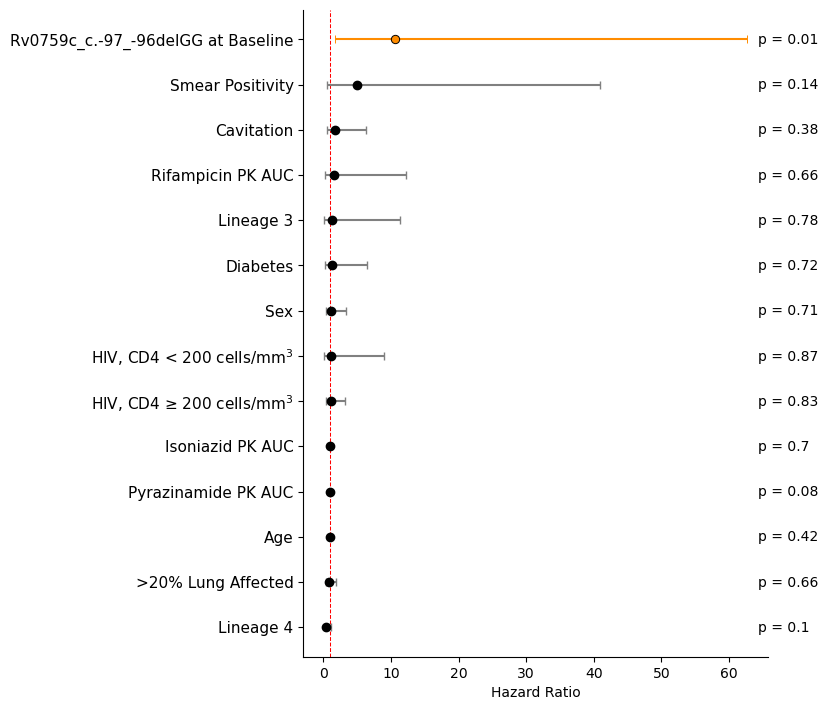

In [191]:
variant = 'Rv0759c_c.-97_-96delGG'
# variant = 'ahpD'

label_dict = {'RIF_AUC': 'Rifampicin PK AUC',
              'INH_AUC': 'Isoniazid PK AUC',
              'EMB_AUC': 'Ethambutol PK AUC',
              'PZA_AUC': 'Pyrazinamide PK AUC',
              'screen_sex': 'Sex',
              'screen_years': 'Age',
              'bl_bmi': 'Body Mass Index',
              'smoked_substance_use': 'Smoked Substance Use',
              'HIV_High_CD4': 'HIV, CD4 ≥ 200 cells/$\mathregular{mm^3}$',
              'HIV_Low_CD4': 'HIV, CD4 < 200 cells/$\mathregular{mm^3}$',
              'INH_midpoing': 'Measured INH MIC',
              'bl_prevtb': 'Previous TB Disease',
              'smear_pos_no_contam_sputum_specimen_1': 'Smear Positivity',
              'diabetes': 'Diabetes',
              'Indel_Change': f'{variant} Gain',
              'Indel_Sample1': f'{variant} at Baseline',
              'Indel_Sample1_x_Change': f'{variant} at Baseline x Gain',
              'Lineage_3': 'Lineage 3',
              'Lineage_4': 'Lineage 4',
              'total_adherence': 'Adherence Rate',
              'F2': 'F2 Strain Mixing Metric',
              'inh_resistant': 'INH Resistance',
              'high_lung_involvement': '>20% Lung Affected',
              'cxr_cavity_chest_radiograph_1': 'Cavitation',
              'fstrom1_baseline': 'Smoking'
             }

forest_plot(df_results_all_indels_outcomes.query("Indel==@variant & covariate != 'inh_resistant' & covariate != 'Indel_Change'"), label_dict, val_col='OR', alpha=0.05)#, saveName=f"./results/figures/outcomes/{variant}.svg")

In [32]:
variant = 'Rv0759c_c.-97_-96delGG'
pids_with_variant = sample_1_variants.loc[sample_1_variants[variant] > 0].index.values

In [33]:
df_tx_outcomes.query("pid in @pids_with_variant")

,pid,date,event_type,to_studyto_treatment_outcome,esp_reason_end_of_study_parti,esp_reasonoth_end_of_study_parti,esp_date_end_of_study_parti,waiver_reason_end_of_study_parti,esp_cod_end_of_study_parti,waiver_deathcause_end_of_study_parti,TB_death,event,reenroll,unique_patient,weeks,months
39,T0049,449.0,relapse,2.0,5.0,NaN,449.0,NaN,NaN,NaN,NaN,1,0,21,64.142857,14.966667
63,T0077,534.0,cure,1.0,1.0,NaN,534.0,NaN,NaN,NaN,NaN,0,0,118,76.285714,17.800000
83,T0106,529.0,cure,1.0,1.0,NaN,529.0,NaN,NaN,NaN,NaN,0,0,140,75.571429,17.633333
99,T0125,593.0,cure,1.0,1.0,NaN,593.0,NaN,NaN,NaN,NaN,0,0,153,84.714286,19.766667
118,T0149,561.0,cure,1.0,1.0,NaN,561.0,NaN,NaN,NaN,NaN,0,0,172,80.142857,18.700000
170,T0205,84.0,cure,9.0,3.0,NaN,84.0,NaN,NaN,NaN,NaN,0,0,219,12.000000,2.800000
180,T0217,76.0,cure,3.0,7.0,NaN,217.0,NaN,NaN,NaN,NaN,0,0,227,10.857143,2.533333
210,T0257,350.0,relapse,1.0,5.0,NaN,350.0,1.0,NaN,NaN,NaN,1,1,5,50.000000,11.666667


In [38]:
df_tx_outcomes.event_type.value_counts()

event_type
cure          230
relapse        18
death          11
tx_failure      4
Name: count, dtype: int64

In [34]:
df_imputed_patient_data_outcomes[['pid', 'inh_resistant']].query("pid in @pids_with_variant").drop_duplicates()

,pid,inh_resistant
39,T0049,0.0
63,T0077,0.0
83,T0106,0.0
100,T0125,0.0
119,T0149,0.0
171,T0205,0.0
181,T0217,0.0
212,T0257,0.0
270,T0330,0.0


In [35]:
df_pred_combined.query("pid in @pids_with_variant")

NameError: name 'df_pred_combined' is not defined

In [36]:
sample_1_variants.loc[sample_1_variants[variant] > 0][variant]

T0049    1.000000
T0077    1.000000
T0091    0.989761
T0106    1.000000
T0125    1.000000
T0149    0.992424
T0205    0.996296
T0217    0.596552
T0257    1.000000
T0330    0.995516
Name: Rv0759c_c.-97_-96delGG, dtype: float64

In [37]:
sample_2_variants.loc[sample_2_variants[variant] > 0][variant]

T0049    1.000000
T0077    0.989796
T0091    1.000000
T0106    1.000000
T0125    0.995781
T0149    0.996835
T0205    0.984375
T0217    0.753247
T0257    0.993769
T0330    1.000000
Name: Rv0759c_c.-97_-96delGG, dtype: float64

In [283]:
indels_difference[variant].value_counts()

Rv0759c_c.-97_-96delGG
 0.000000    267
-0.009950      1
 0.009868      1
-0.004049      1
-0.007475      1
 0.164983      1
-0.005848      1
 0.004255      1
Name: count, dtype: int64

In [144]:
search_pids = sample_1_variants.loc[sample_1_variants[variant] > 0.05].index.values
len(search_pids)

9

In [145]:
df_tx_outcomes.query("pid in @search_pids")[['pid', 'event_type', 'date', 'event']]

,pid,event_type,date,event
39,T0049,relapse,449.0,1
63,T0077,cure,534.0,0
83,T0106,cure,529.0,0
99,T0125,cure,593.0,0
170,T0205,cure,84.0,0
180,T0217,cure,76.0,0
210,T0257,relapse,350.0,1


In [277]:
df_imputed_patient_data_single_variant.loc[df_imputed_patient_data_single_variant['.imp']==0].query("pid in @search_pids").T

,39,63,83,100,171,181,212
.imp,0,0,0,0,0,0,0
.id,40,64,84,101,172,182,213
pid,T0049,T0077,T0106,T0125,T0205,T0217,T0257
screen_sex,0,1,1,0,1,0,0
screen_years,32,53,56,61,32,18,48
bl_bmi,16.3,13.3,20.3,35.5,17.8,13.9,21.1
fstrom1_baseline,0,1,0,1,1,1,1
bl_hiv,1,0,0,0,1,0,0
bl_cd4,1005.0,NaN,NaN,NaN,208.0,NaN,NaN
bl_prevtb,0,1,0,0,0,1,0


In [148]:
search_patients = sample_1_variants.loc[sample_1_variants[variant] > 0.05].index.values

plot_AF_matrix = df_variants.query("pid in @search_patients & variant == @variant").pivot(index='pid', columns='Paired_Sample_Num', values='AF').fillna(0)
plot_AF_matrix.columns = ['Sample1', 'Sample2']
plot_AF_matrix = plot_AF_matrix.reset_index().merge(indels_difference[variant], left_on='pid', right_index=True).sort_values(variant)
plot_AF_matrix

,pid,Sample1,Sample2,Rv0759c_c.-97_-96delGG
1,T0077,1.000000,0.990050,-0.009950
5,T0205,0.996364,0.988889,-0.007475
7,T0257,1.000000,0.994152,-0.005848
4,T0125,1.000000,0.995951,-0.004049
0,T0049,1.000000,1.000000,0.000000
3,T0106,1.000000,1.000000,0.000000
8,T0330,0.995745,1.000000,0.004255
2,T0091,0.990132,1.000000,0.009868
6,T0217,0.592593,0.757576,0.164983


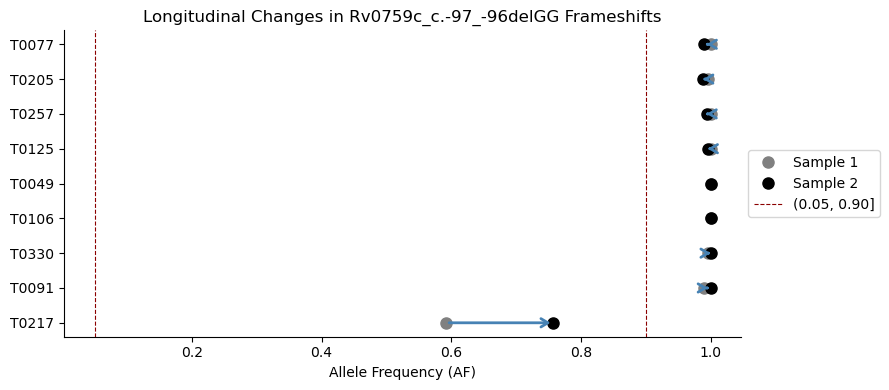

In [149]:
fig, ax = plt.subplots(figsize=(9, 4))

# Loop through samples and draw arrows
for i, row in plot_AF_matrix.iloc[::-1, :].iterrows():
    ax.annotate(
        '', xy=(row['Sample2'], row['pid']), xytext=(row['Sample1'], row['pid']),
        arrowprops=dict(arrowstyle='->,head_length=0.5,head_width=0.3', color='steelblue', lw=2)
    )
    # add point markers for the AFs
    ax.plot(row['Sample1'], row['pid'], 'o', color='gray', zorder=0, markersize=8, label='Sample 1')
    ax.plot(row['Sample2'], row['pid'], 'o', color='black', zorder=0, markersize=8, label='Sample 2')

# plt.axvline(0.05, color='darkred', linestyle='--', linewidth=0.8, label = '(0.05, 0.90]')
# plt.axvline(0.90, color='darkred', linestyle='--', linewidth=0.8, label = '(0.05, 0.90]')
ax.set_xlabel('Allele Frequency (AF)')
# ax.set_ylabel('Sample')
ax.set_title(f'Longitudinal Changes in {variant} Frameshifts')
# plt.grid(axis='x', linestyle='--', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig(f"./results/figures/{variant}_within_sample_changes.svg")